# Analytics

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Lorrany Azevedo
- Guilherme Guy
- Alexandre 

### LIBRARIES

In [1711]:
%matplotlib inline

In [1712]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

### GRAPH SETTINGS

In [1713]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [1714]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

In [1715]:
repos = [
    '2021.1-Cartografia-social-api-comunidades',
    '2021.1-Cartografia-social-api-gateway',
    '2021.1-Cartografia-social-api-mapas',
    '2021.1-Cartografia-social-api-midia',
    '2021.1-Cartografia-social-api-users',
    '2021.1-Cartografia-social-api-front',
]

language = [['2021.1-Cartografia-social-api-comunidades', 'ts'], 
            ['2021.1-Cartografia-social-api-gateway', 'ts'], 
            ['2021.1-Cartografia-social-api-mapas', 'ts'], 
            ['2021.1-Cartografia-social-api-midia', 'ts'], 
            ['2021.1-Cartografia-social-api-users', 'ts'], 
            ['2021.1-Cartografia-social-api-front', 'js']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

In [1716]:
repos_language

{'2021.1-Cartografia-social-api-comunidades': 'ts',
 '2021.1-Cartografia-social-api-gateway': 'ts',
 '2021.1-Cartografia-social-api-mapas': 'ts',
 '2021.1-Cartografia-social-api-midia': 'ts',
 '2021.1-Cartografia-social-api-users': 'ts',
 '2021.1-Cartografia-social-api-front': 'js'}

##### Path to the folder with all your jsons

In [1717]:
jsons = glob('**/*.json') # add the path here

In [1718]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-(.*?)_(.*?)_(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[3]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [1719]:
base_component_df = create_base_component_df(jsons)
#print(base_component_df)

In [1720]:
#base_component_df.head(50)

#### Create dataframe per file

In [1721]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [1722]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')
        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        
        file_component_df['filename'] = os.path.basename(i)
        file_component_df_js['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        df = df.append(file_component_df_js, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021_1-(.*?)_(.*?)_(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[3]
    
    df = df.sort_values(by=['repository', 'version'])
    df.to_csv('result2.csv')
    
    return df

In [1723]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()
#file_component_df.head(1000)

array(['Cartografia-social-api-comunidades',
       'Cartografia-social-api-front', 'Cartografia-social-api-gateway',
       'Cartografia-social-api-mapas', 'Cartografia-social-api-midia',
       'Cartografia-social-api-users'], dtype=object)

#### Create dataframe per repository

In [1724]:
repository_dataframes = {} 

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df
    
repository_dataframes.keys()

dict_keys(['2021.1-Cartografia-social-api-comunidades', '2021.1-Cartografia-social-api-gateway', '2021.1-Cartografia-social-api-mapas', '2021.1-Cartografia-social-api-midia', '2021.1-Cartografia-social-api-users', '2021.1-Cartografia-social-api-front'])

In [1725]:
api_comunidades_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-comunidades']
api_gateway_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-gateway']
api_mapas_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-mapas']
api_midia_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-midia']
api_users_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-users']
front_df = file_component_df[file_component_df['repository'] == 'Cartografia-social-api-front']
#print(front_df)

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [1726]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [1727]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [1728]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

In [1729]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)
    
    return ncloc

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [1730]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [1731]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [1732]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [1733]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list
                              })
        
    return metrics_df

In [1734]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df
    
repository_dataframes.keys()

dict_keys(['2021.1-Cartografia-social-api-comunidades', '2021.1-Cartografia-social-api-gateway', '2021.1-Cartografia-social-api-mapas', '2021.1-Cartografia-social-api-midia', '2021.1-Cartografia-social-api-users', '2021.1-Cartografia-social-api-front'])

In [1735]:
api_comunidades_metrics = create_metrics_df(api_comunidades_df)
api_gateway_metrics = create_metrics_df(api_gateway_df)
api_mapas_metrics = create_metrics_df(api_mapas_df)
api_midia_metrics = create_metrics_df(api_midia_df)
api_users_metrics = create_metrics_df(api_users_df)
front_metrics = create_metrics_df(front_df)
#print(front_metrics)
...

Ellipsis

In [1736]:
all_metrics = pd.concat([api_comunidades_metrics, api_gateway_metrics, api_mapas_metrics, api_midia_metrics, api_users_metrics, front_metrics], ignore_index=True)

# Visualização dos Dados de [Maintainability e Reliability] 

- De cada repositório do nosso micro-serviço

## Análise de estatistica descritiva

- Realiza o cálculo de dados estatísticos de medidas de tendência central, como média, mediana, moda e percentis. Já as medidas de dispersão são o mínimo, máximo, desvio padrão e variância.Esta fase é a fase inicial da nossa análise de dados para descrever e resumir os nossos dados análisados.

Interpretando os dados:

- Média: Média dos valores do conjunto de dados
- Mediana: A mediana é o valor da váriavel que ocupa posição central do conjunto de dados ordenado. Na tabela de análise descritiva o valor 50% é o valor da mediana, e os valores de 75% e 25% são os percentis superiores e inferiores respectivamente, para uma melhor visualização ao fim da tabela foi adicionado um campo chamado mediana, porém o mesmo é igual ao valor de 50% já apresentado.
- Moda: Valor mais recorrente do conjunto de dados.
- Máximo: Maior valor do conjunto de dados
- Desvio padrão (std): Indica a dispersão do conjunto de dados, quanto mais próximo esse valor estiver de 0 mais homogêneo é o conjunto.
- Variância: Menor valor do conjunto de dados.
- Percentis: Os percentis incluidos na saída estão entre 0 e 1 e retornam o percentis de 25%, 50% e 75%

In [1737]:
def descriptive_statistics(df):
    #Gera uma estatísticas descritivas excluindo NaN values
    metrics = df.describe()
    
    
    median = df.median()
  
    variance = df.var()
    variance_df = pd.DataFrame({"var": variance,
                               "median": median})
    
    variance_df = variance_df.T
    
    return metrics.append(variance_df).T

## Matriz de Correlação

* Duas estátisticas estão correlacionadas quando existe qualquer associação estatística entre elas, essa correlação pode ser o quão porximas duas váriavéis estão de ter uma relação linear entre si. Aqui usamos a correlação de Pearson onde os valores de r vão de -1 a 1, essa correlação é positiva quando r > 0, isso significa que ambas as váriaveis se movem na mesmas direção, ou essa correlação pode ser negativa (r < 0), que é quando as váriaveis andam em direções opostas.

- Correlação positiva: ambas as variáveis mudam na mesma direção. (r > 0)
 - Correlação Nula: Nenhuma relação na mudança das variáveis. (r = 0 ou Nulo)
- Correlação Negativa: as variáveis mudam em direções opostas. (r < 0)

* Pela fórmula a correlação é um número entre -1 e 1 e interpretamos da seguinte maneira: quanto mais o r estiver próximo de 1 ou -1 mais forte será a correlação.

https://rstudio-pubs-static.s3.amazonaws.com/437792_df39a5ff0a55491fb71f0f4a0f5cd0bf.html

In [1738]:
def correlationMatrix(df):
    corrMatrix = df.corr(method='pearson')
    return corrMatrix

### Percentis Table

Medida que divide uma amostra de dados ordenados de forma crescente em 100 partes. Calculamos o percentis de 0% a 99% da amostra para cada métrica pois assim poderemos analisar por exemplo em quantos porcento determinado tempo é levado para executar a build de teses. 

In [1739]:
def descriptive_per(df):
    #Gera uma estatísticas descritivas excluindo NaN values
    metrics = df.describe(percentiles=[0.0, 0.10, 0.20, 0.30, 0.40, 0.60, 0.70, 0.80, 0.99])
    metrics = metrics.drop(index=['count', 'std', 'mean', 'min', 'max'])
    return metrics

### Gráfico Box-Plot

- Nos ajuda a observar a variação das métricas coletadas por meio do quartis, ous seja dos percentis inferiores e superiores juntamente com a mediana, na tabela de análise descritiva podemos ver o percentil inferior representado pelo valor 25%, a mediana 50%, e o percentis superior como 75%. Além do quartis temos nesses gráficos também os outliers representados por bolinhas, que são os valores descrepantes plotados como pontos individuais, esses pontos são os pontos que ultrapassam os limites inferiores e superiores dos nossos dados. 

In [1740]:
def generate_box(data, repository):
    df = pd.DataFrame(data,
                      columns=['m1', 'm2', 'm3', 'm4', 'm5', 'm6'])
    
    #print(f"Meu df {df}")
    plt.title(f"{repository}")
    boxplot = df.boxplot(column=['m1', 'm2', 'm3', 'm4', 'm5', 'm6'], figsize=(20,10))
    

In [1741]:
#plot history
def plot_history(df, repository):
    
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMPLEXITY")
    plt.plot(df['m1'], linewidth=3, marker='o', markersize=10)
    
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMMENTS")
    plt.plot(df['m2'], linewidth=3, marker='o', markersize=10)
    
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:DUPLICATIONS")
    plt.plot(df['m3'], linewidth=3, marker='o', markersize=10)
    
#    fig = plt.figure(figsize=(20, 10))
#    plt.title(f"{repository}:PASSED TESTS")
#    plt.plot(df['m4'], linewidth=3, marker='o', markersize=10)
    
#    fig = plt.figure(figsize=(20, 10))
#    plt.title(f"{repository}:FAST TESTS BUILD")
#    plt.plot(df['m4'], linewidth=3, marker='o', markersize=10)

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-front

In [1742]:
generic_df = front_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-FRONT"
generic_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc
0,0.818182,0.000000,1.000000,1.000000,1.000000,1.000000,Cartografia-social-api-front,MVP,1921
1,0.690909,0.036364,1.000000,1.000000,1.000000,1.000000,Cartografia-social-api-front,v0.0.1,1412
2,0.690909,0.036364,1.000000,1.000000,1.000000,1.000000,Cartografia-social-api-front,v0.0.2,1412
3,0.600000,0.000000,1.000000,1.000000,1.000000,1.000000,Cartografia-social-api-front,v0.0.3,525
4,0.600000,0.000000,1.000000,1.000000,1.000000,1.000000,Cartografia-social-api-front,v0.0.4,525
5,0.722222,0.000000,0.944444,0.944444,0.944444,0.944444,Cartografia-social-api-front,v0.0.5,975
6,0.750000,0.000000,0.950000,0.950000,0.950000,0.950000,Cartografia-social-api-front,v0.0.6,1077
7,0.814815,0.000000,1.000000,1.000000,1.000000,1.000000,Cartografia-social-api-front,v0.0.8,1625
8,0.833333,0.000000,1.000000,1.000000,1.000000,1.000000,Cartografia-social-api-front,v0.0.9,1788
9,0.828571,0.000000,0.942857,0.942857,0.942857,0.942857,Cartografia-social-api-front,v1.0.0,2086


### Plot do Histórico das métricas - Front

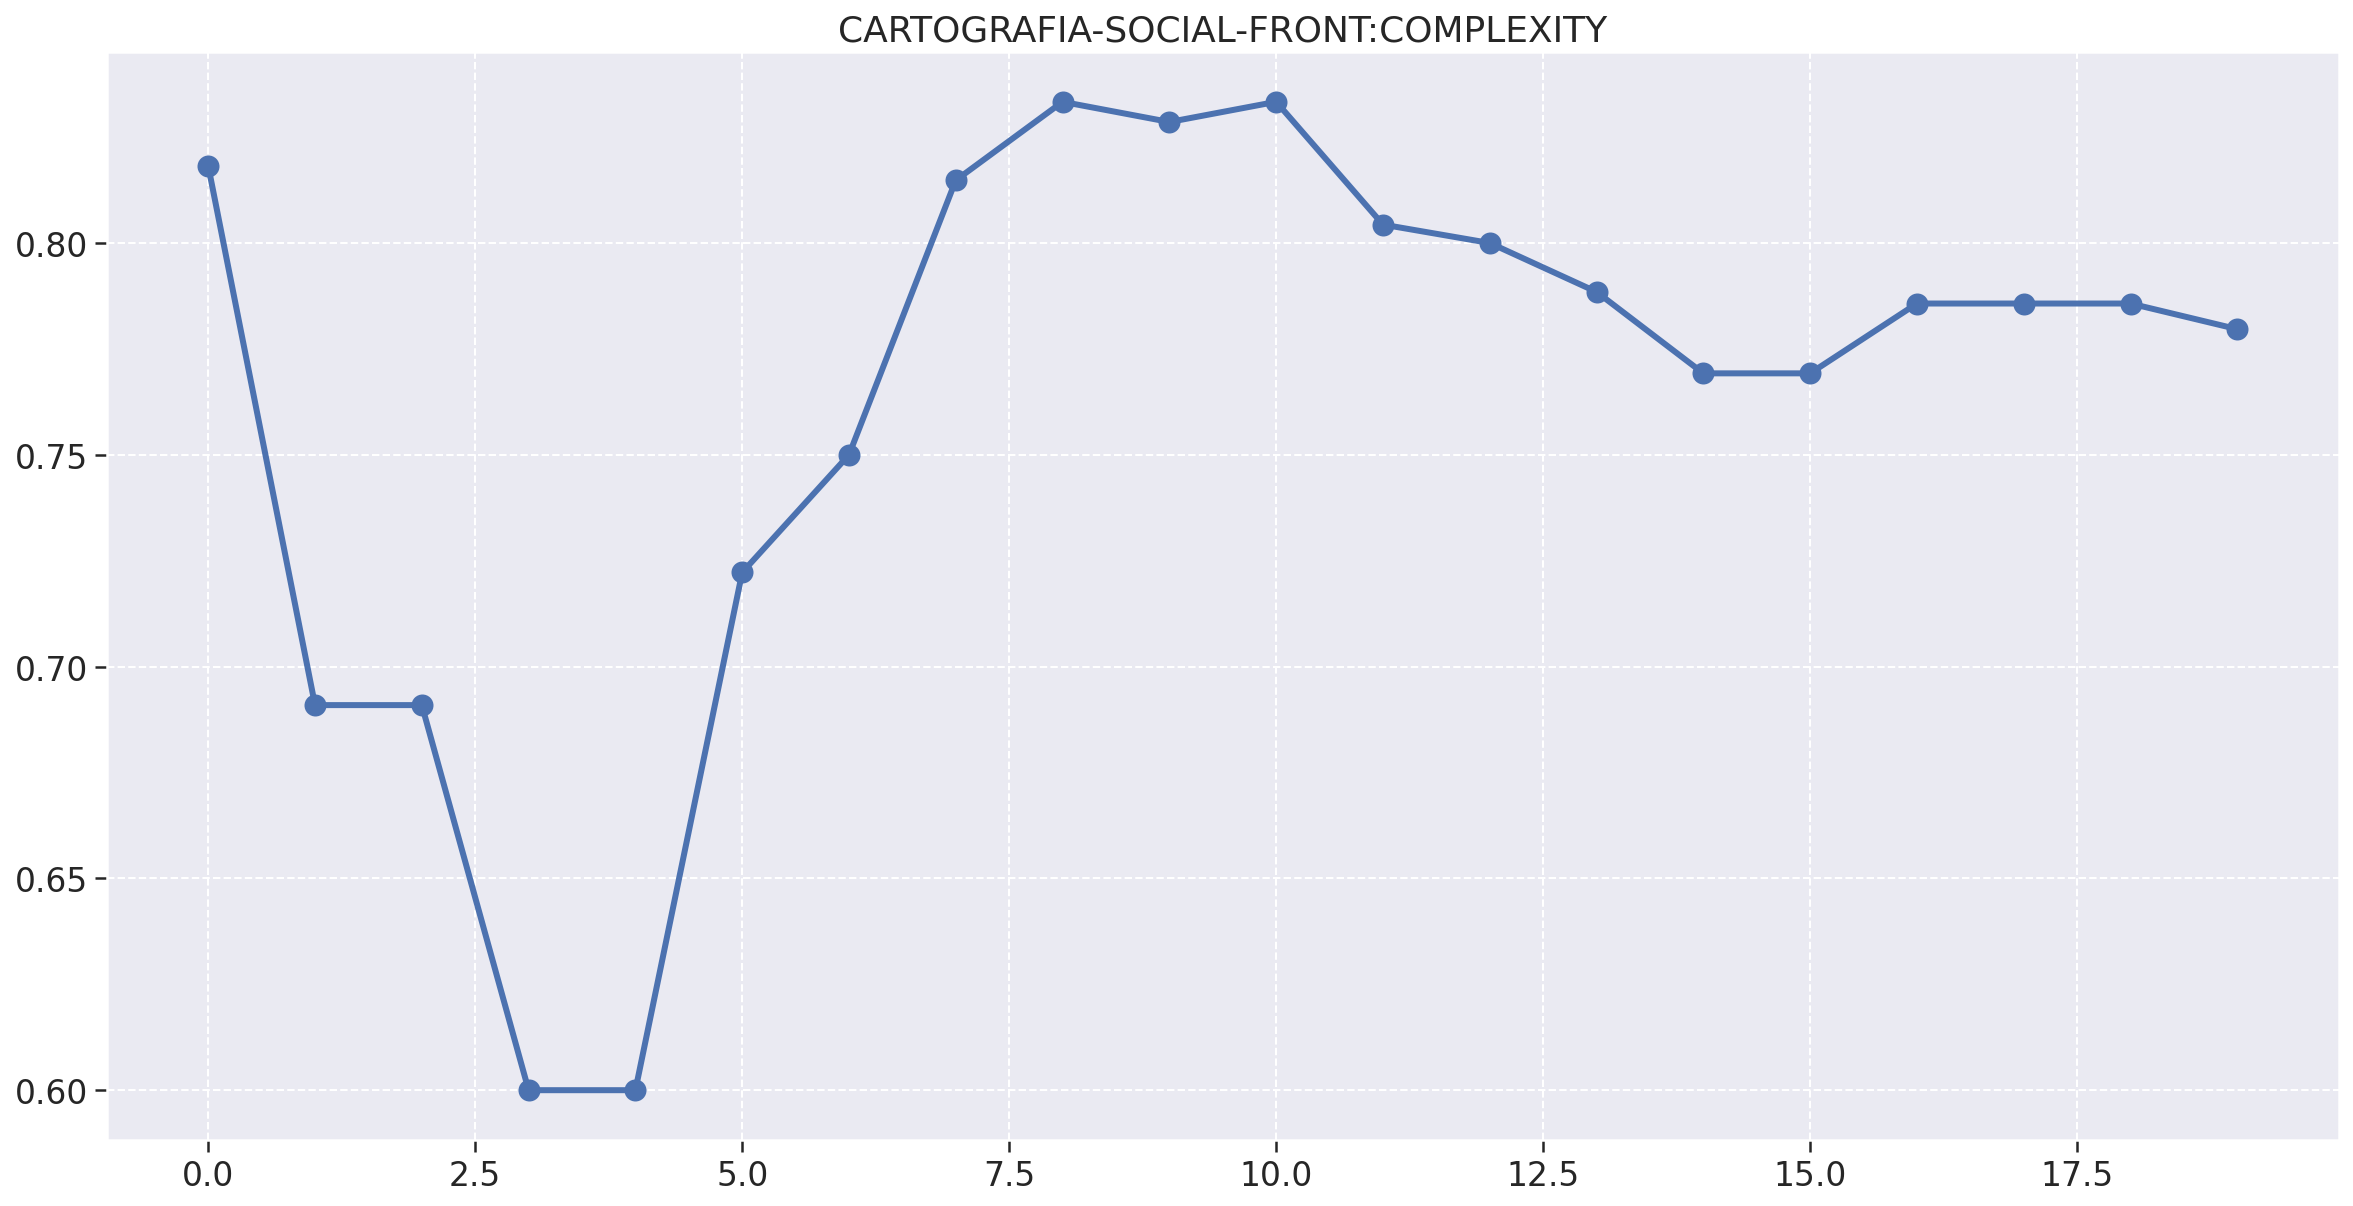

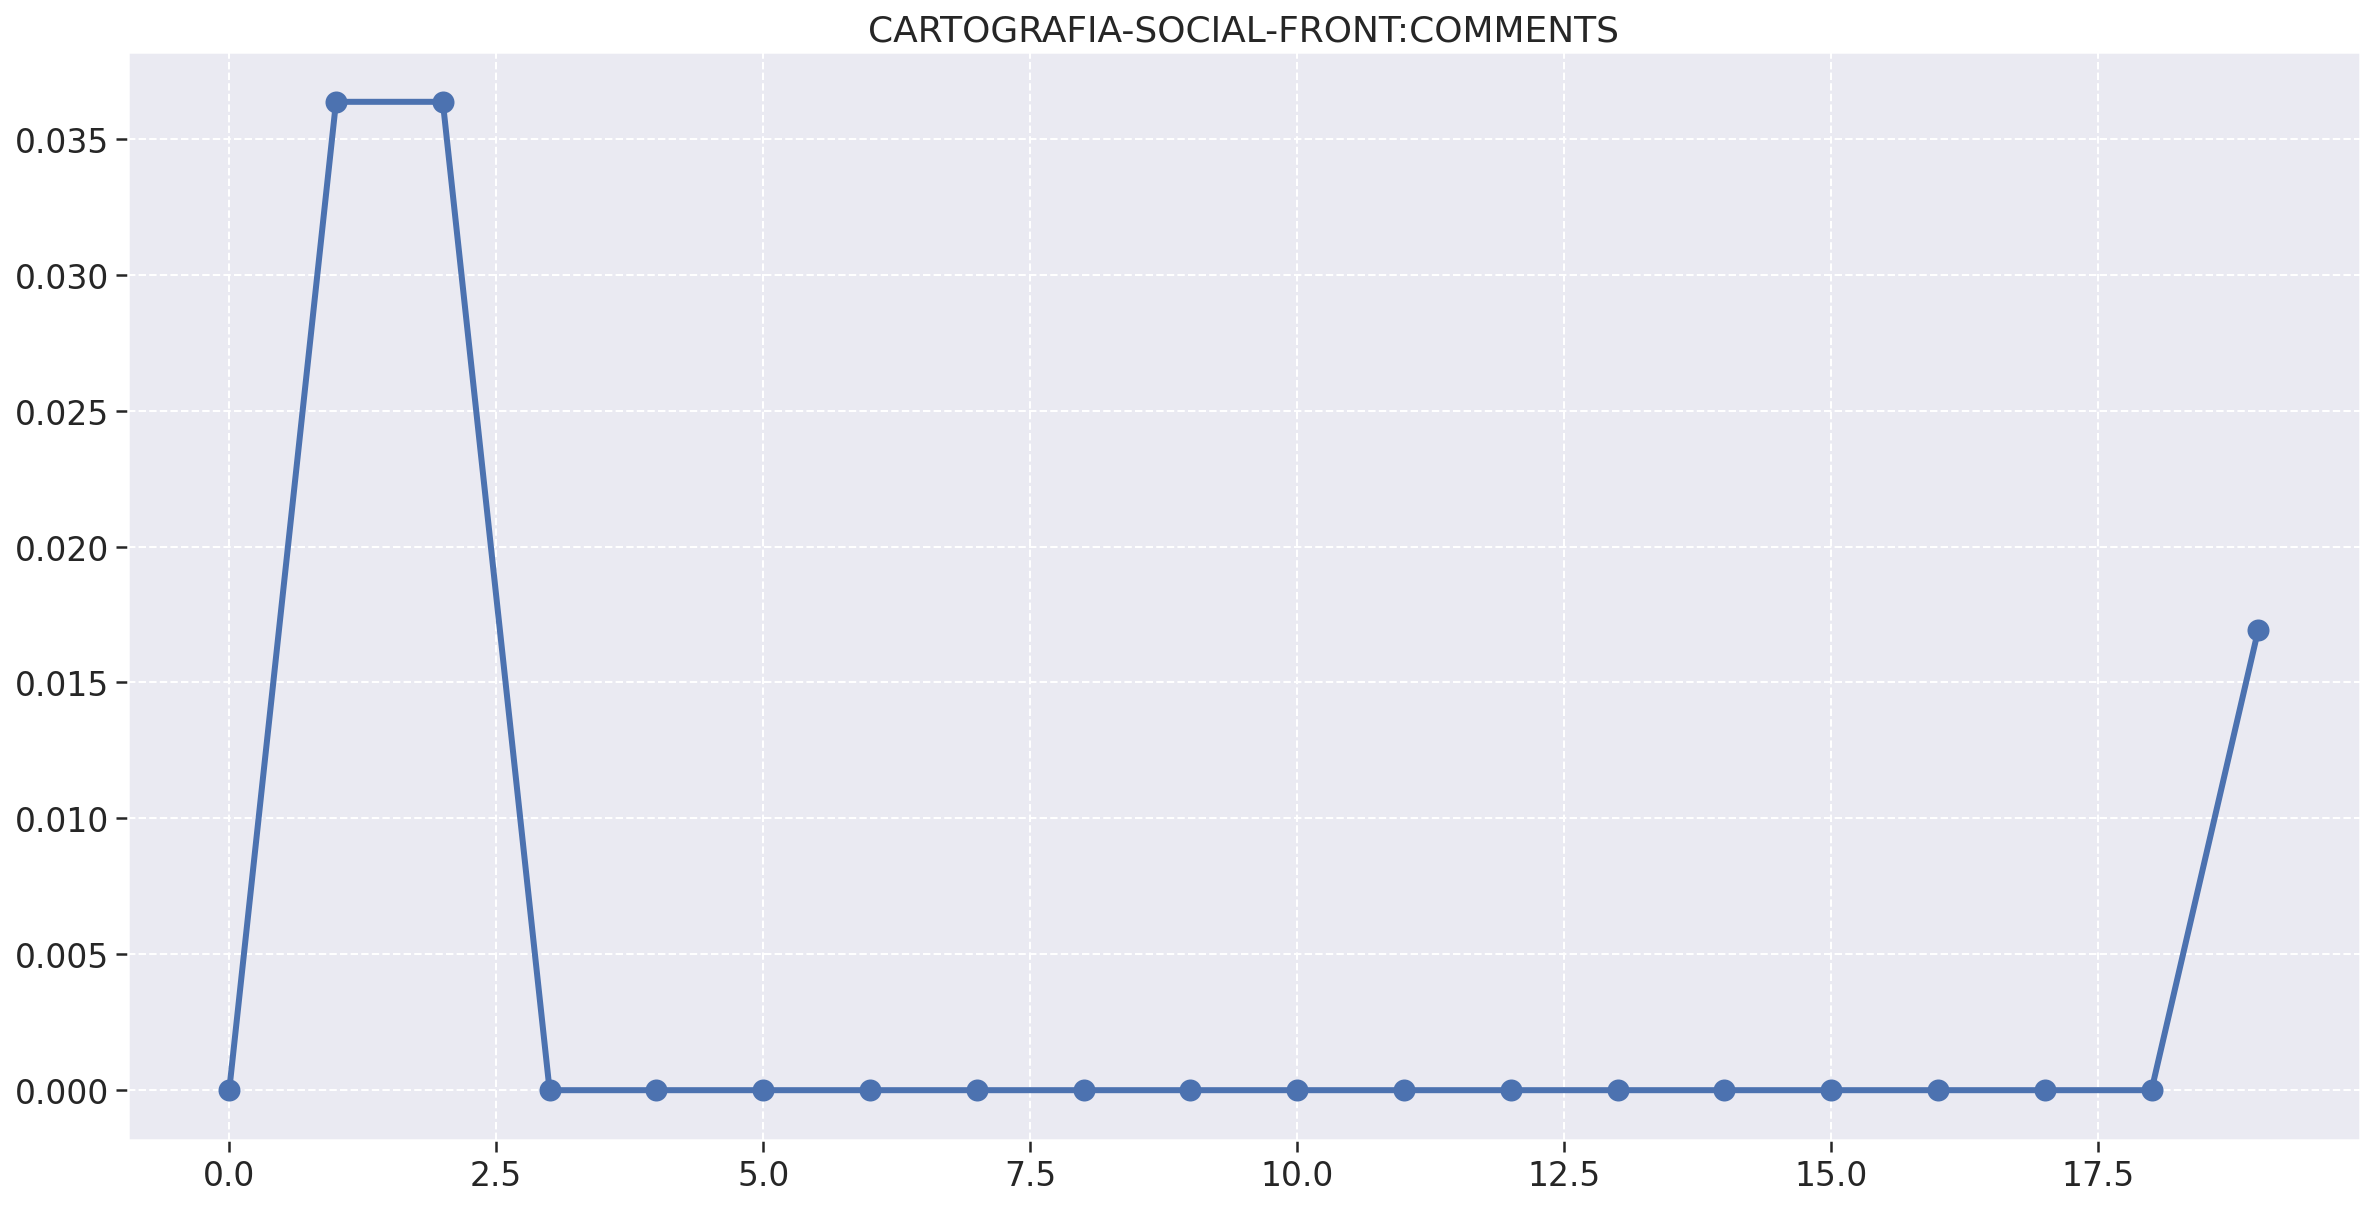

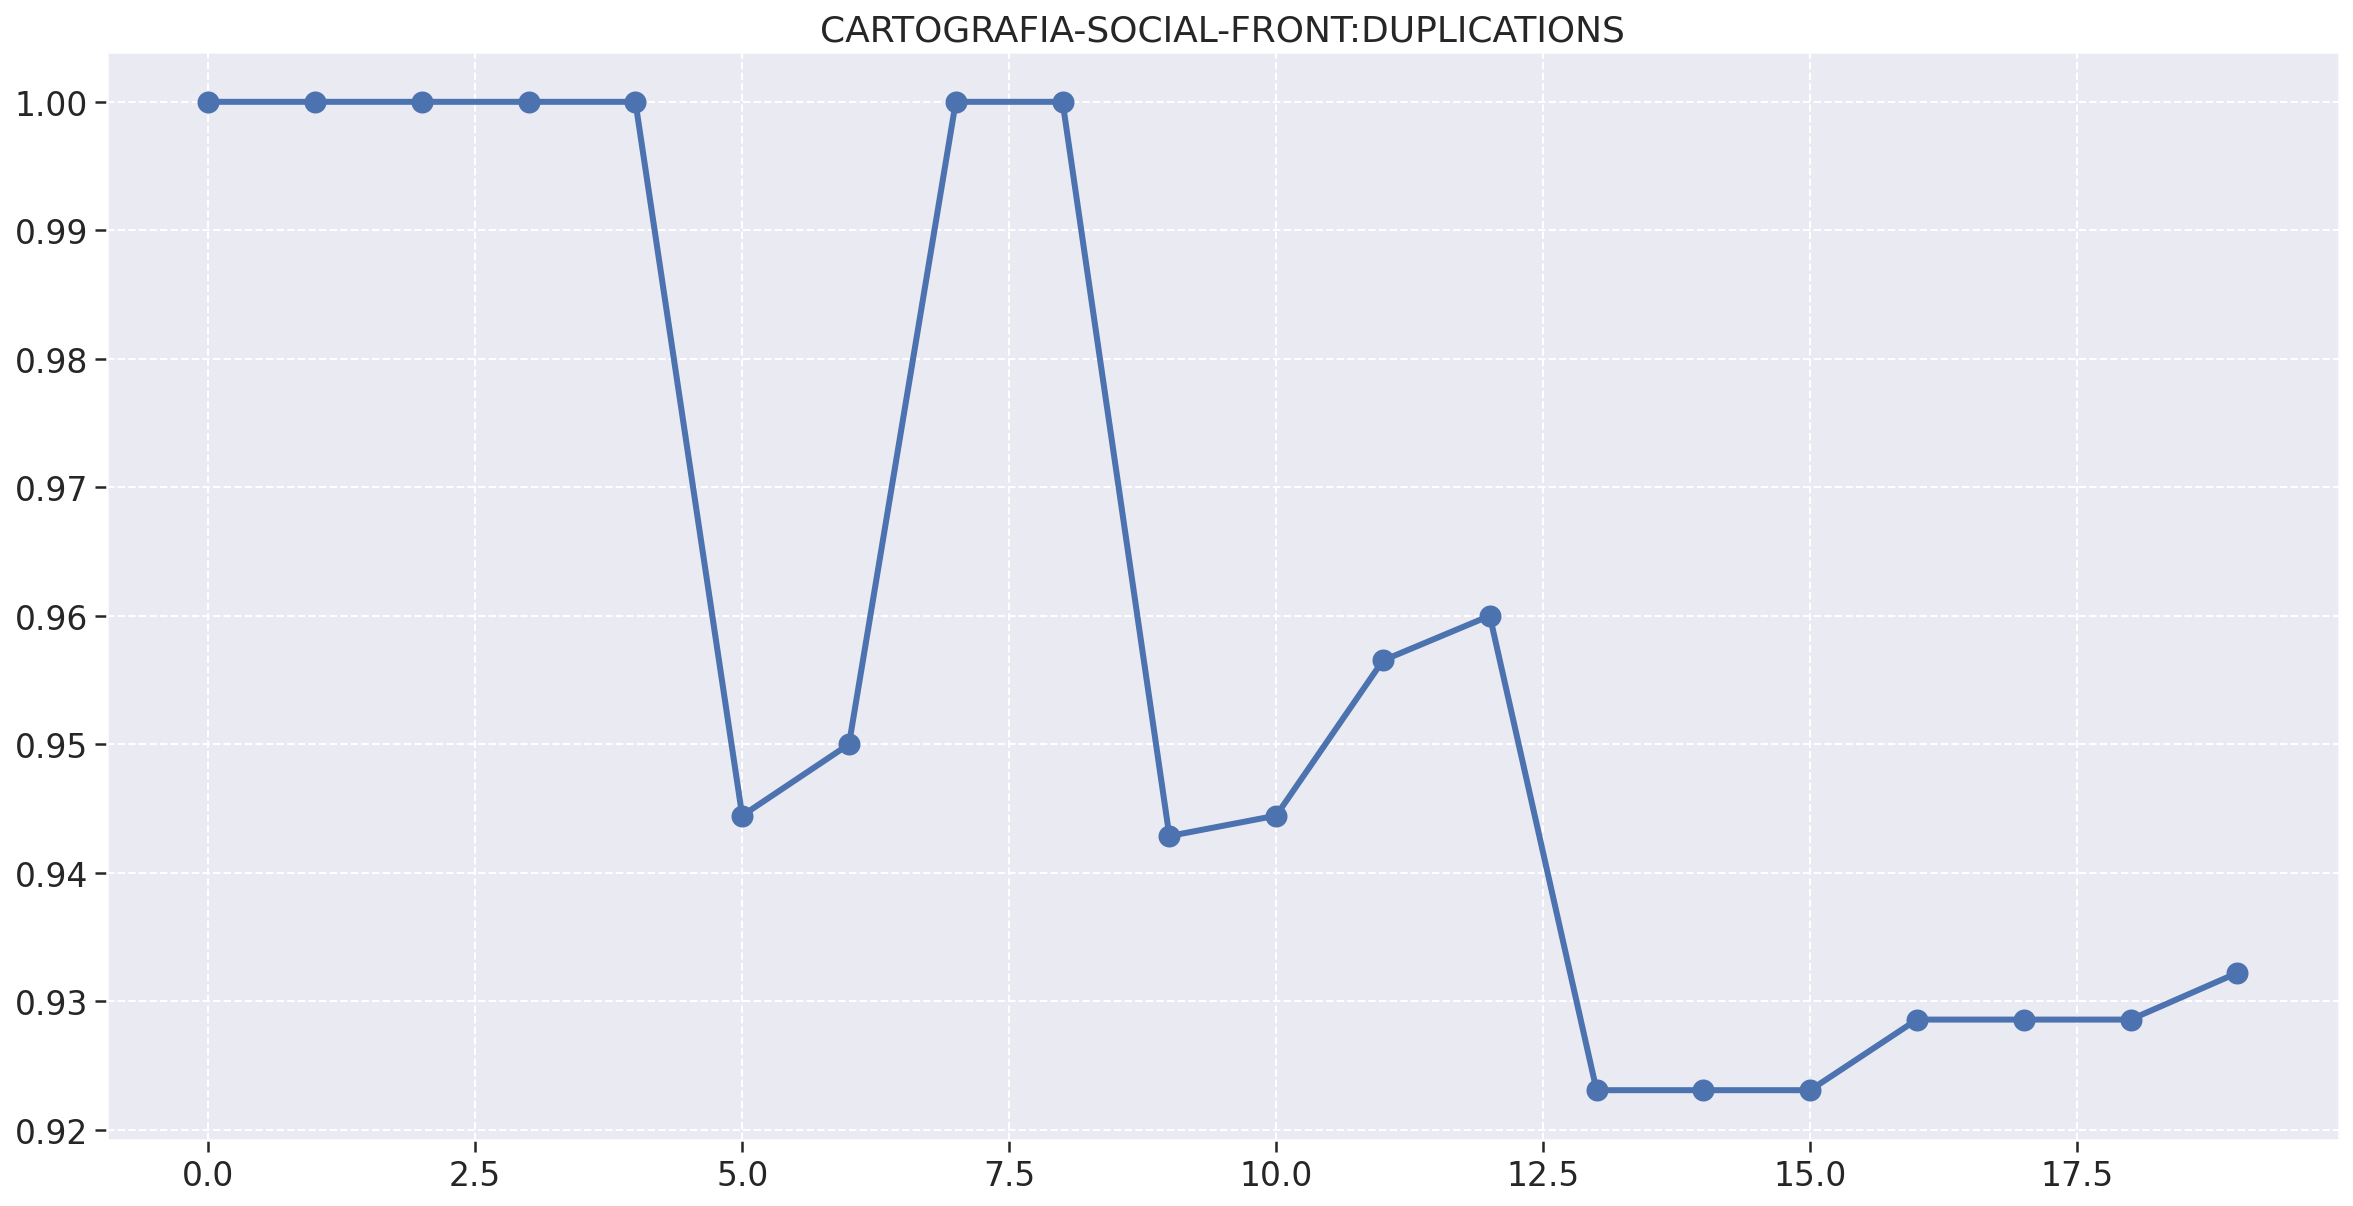

In [1743]:
plot_history(generic_df, repository)

### Estatistica descritiva - Front

In [1744]:
descriptive_statistics(generic_df)

,count,mean,std,min,25%,50%,75%,max,var,median
m1,20.0,0.762517,0.069173,0.600000,0.743056,0.785714,0.806965,0.833333,4.784859e-03,0.785714
m2,20.0,0.004484,0.011539,0.000000,0.000000,0.000000,0.000000,0.036364,1.331478e-04,0.000000
m3,20.0,0.959271,0.032367,0.923077,0.928571,0.947222,1.000000,1.000000,1.047639e-03,0.947222
m4,20.0,0.959271,0.032367,0.923077,0.928571,0.947222,1.000000,1.000000,1.047639e-03,0.947222
m5,20.0,0.959271,0.032367,0.923077,0.928571,0.947222,1.000000,1.000000,1.047639e-03,0.947222
m6,20.0,0.959271,0.032367,0.923077,0.928571,0.947222,1.000000,1.000000,1.047639e-03,0.947222
ncloc,20.0,2226.650000,1043.495910,525.000000,1412.000000,2111.000000,3091.000000,3695.000000,1.088884e+06,2111.000000


### Cálculo da moda - Front

In [1745]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc
0,0.785714,0.0,1.0,1.0,1.0,1.0,525
1,NaN,NaN,NaN,NaN,NaN,NaN,1412
2,NaN,NaN,NaN,NaN,NaN,NaN,3091
3,NaN,NaN,NaN,NaN,NaN,NaN,3511


### Tabela de porcentagem - Front

In [1746]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc
0%,0.600000,0.000000,0.923077,0.923077,0.923077,0.923077,525.0
10%,0.681818,0.000000,0.923077,0.923077,0.923077,0.923077,930.0
20%,0.715960,0.000000,0.928571,0.928571,0.928571,0.928571,1345.0
30%,0.763462,0.000000,0.931114,0.931114,0.931114,0.931114,1561.1
40%,0.775489,0.000000,0.943810,0.943810,0.943810,0.943810,1867.8
50%,0.785714,0.000000,0.947222,0.947222,0.947222,0.947222,2111.0
60%,0.786813,0.000000,0.957913,0.957913,0.957913,0.957913,2751.4
70%,0.801304,0.000000,1.000000,1.000000,1.000000,1.000000,3067.2
80%,0.815488,0.000000,1.000000,1.000000,1.000000,1.000000,3175.0
99%,0.833333,0.036364,1.000000,1.000000,1.000000,1.000000,3666.5


### Matriz de correlação - Front

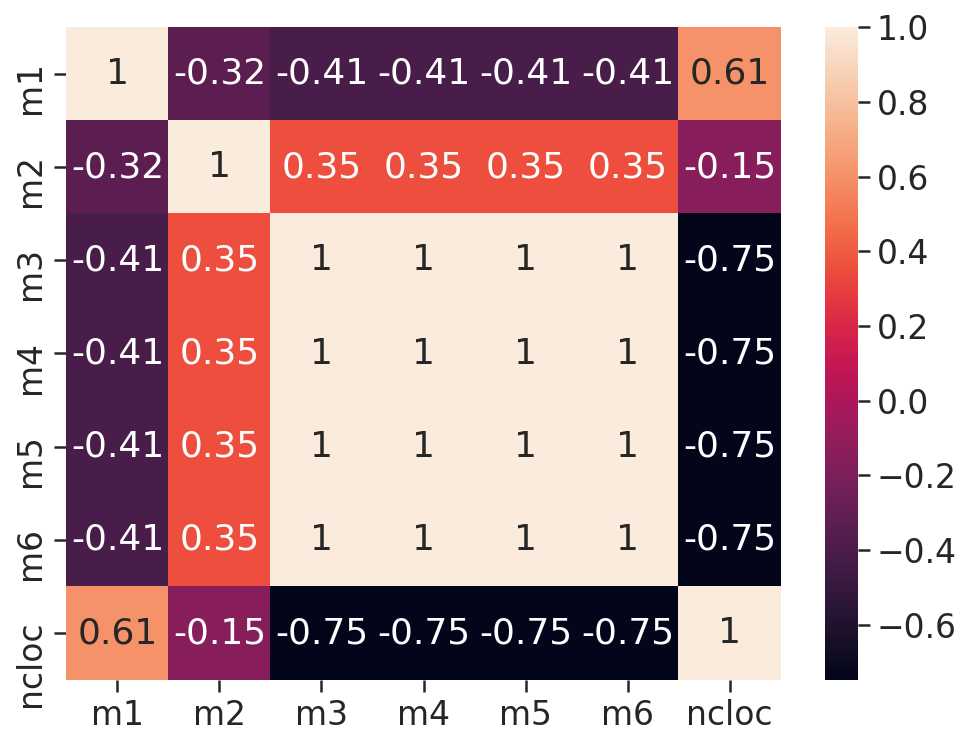

In [1747]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Boxplot - Front

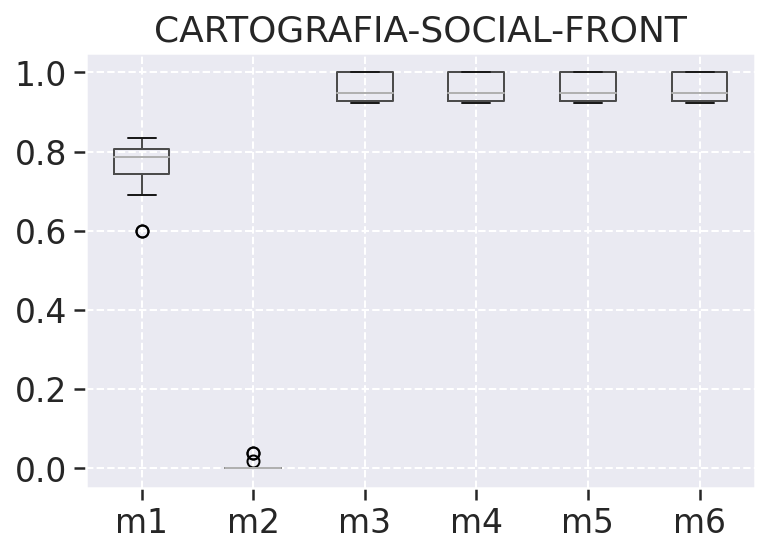

In [1748]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-comunidades

In [1749]:
generic_df = api_comunidades_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-COMUNIDADES"

### Plot do Histórico das métricas - comunidades

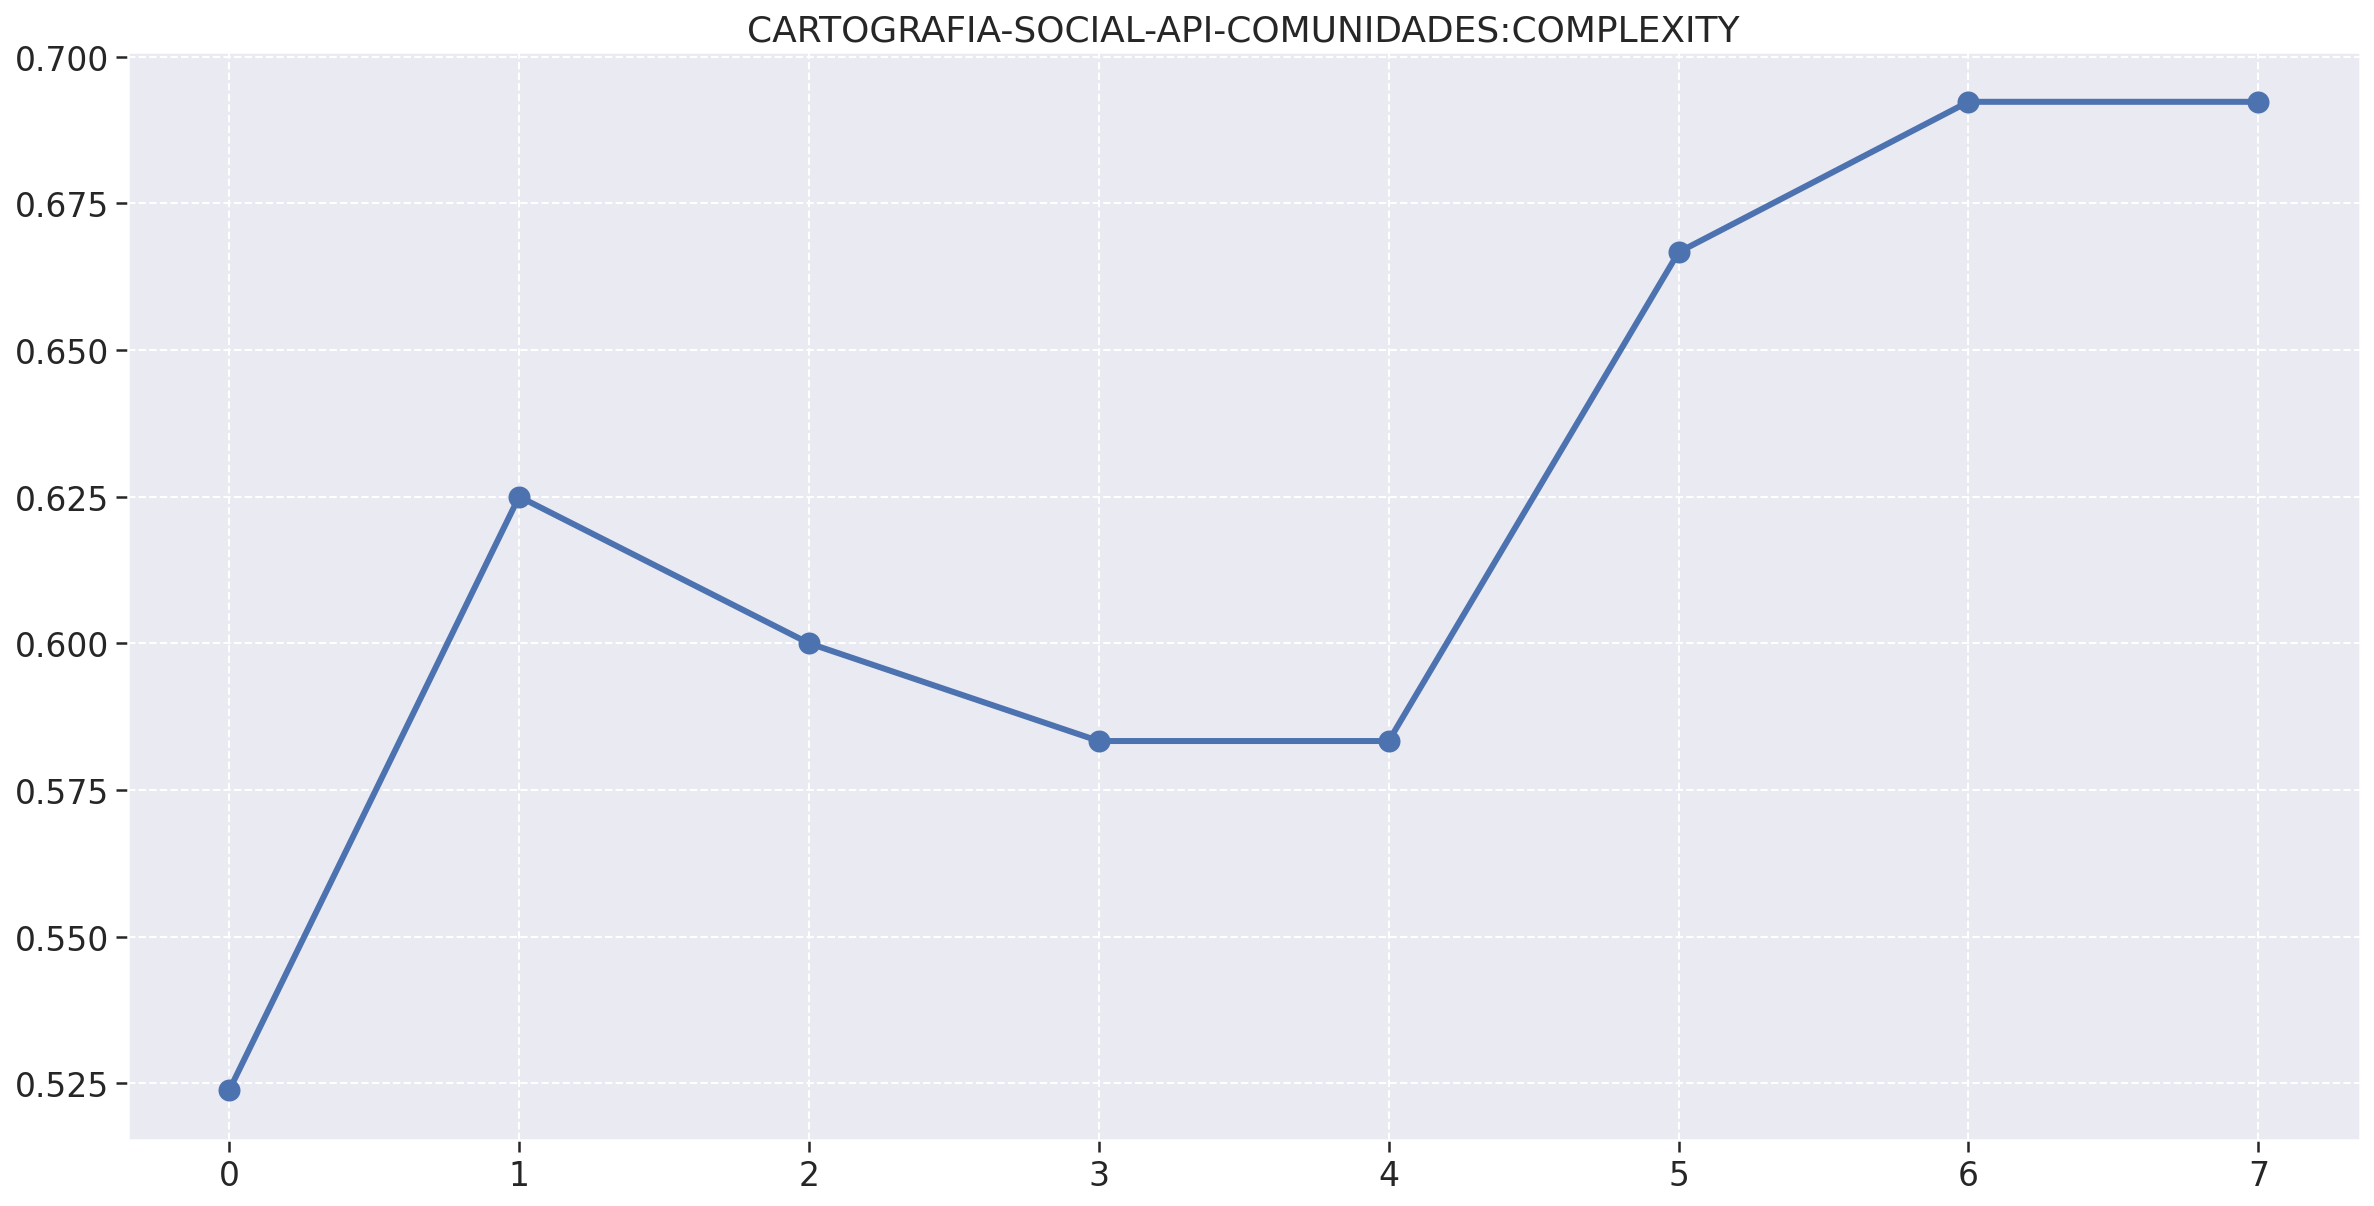

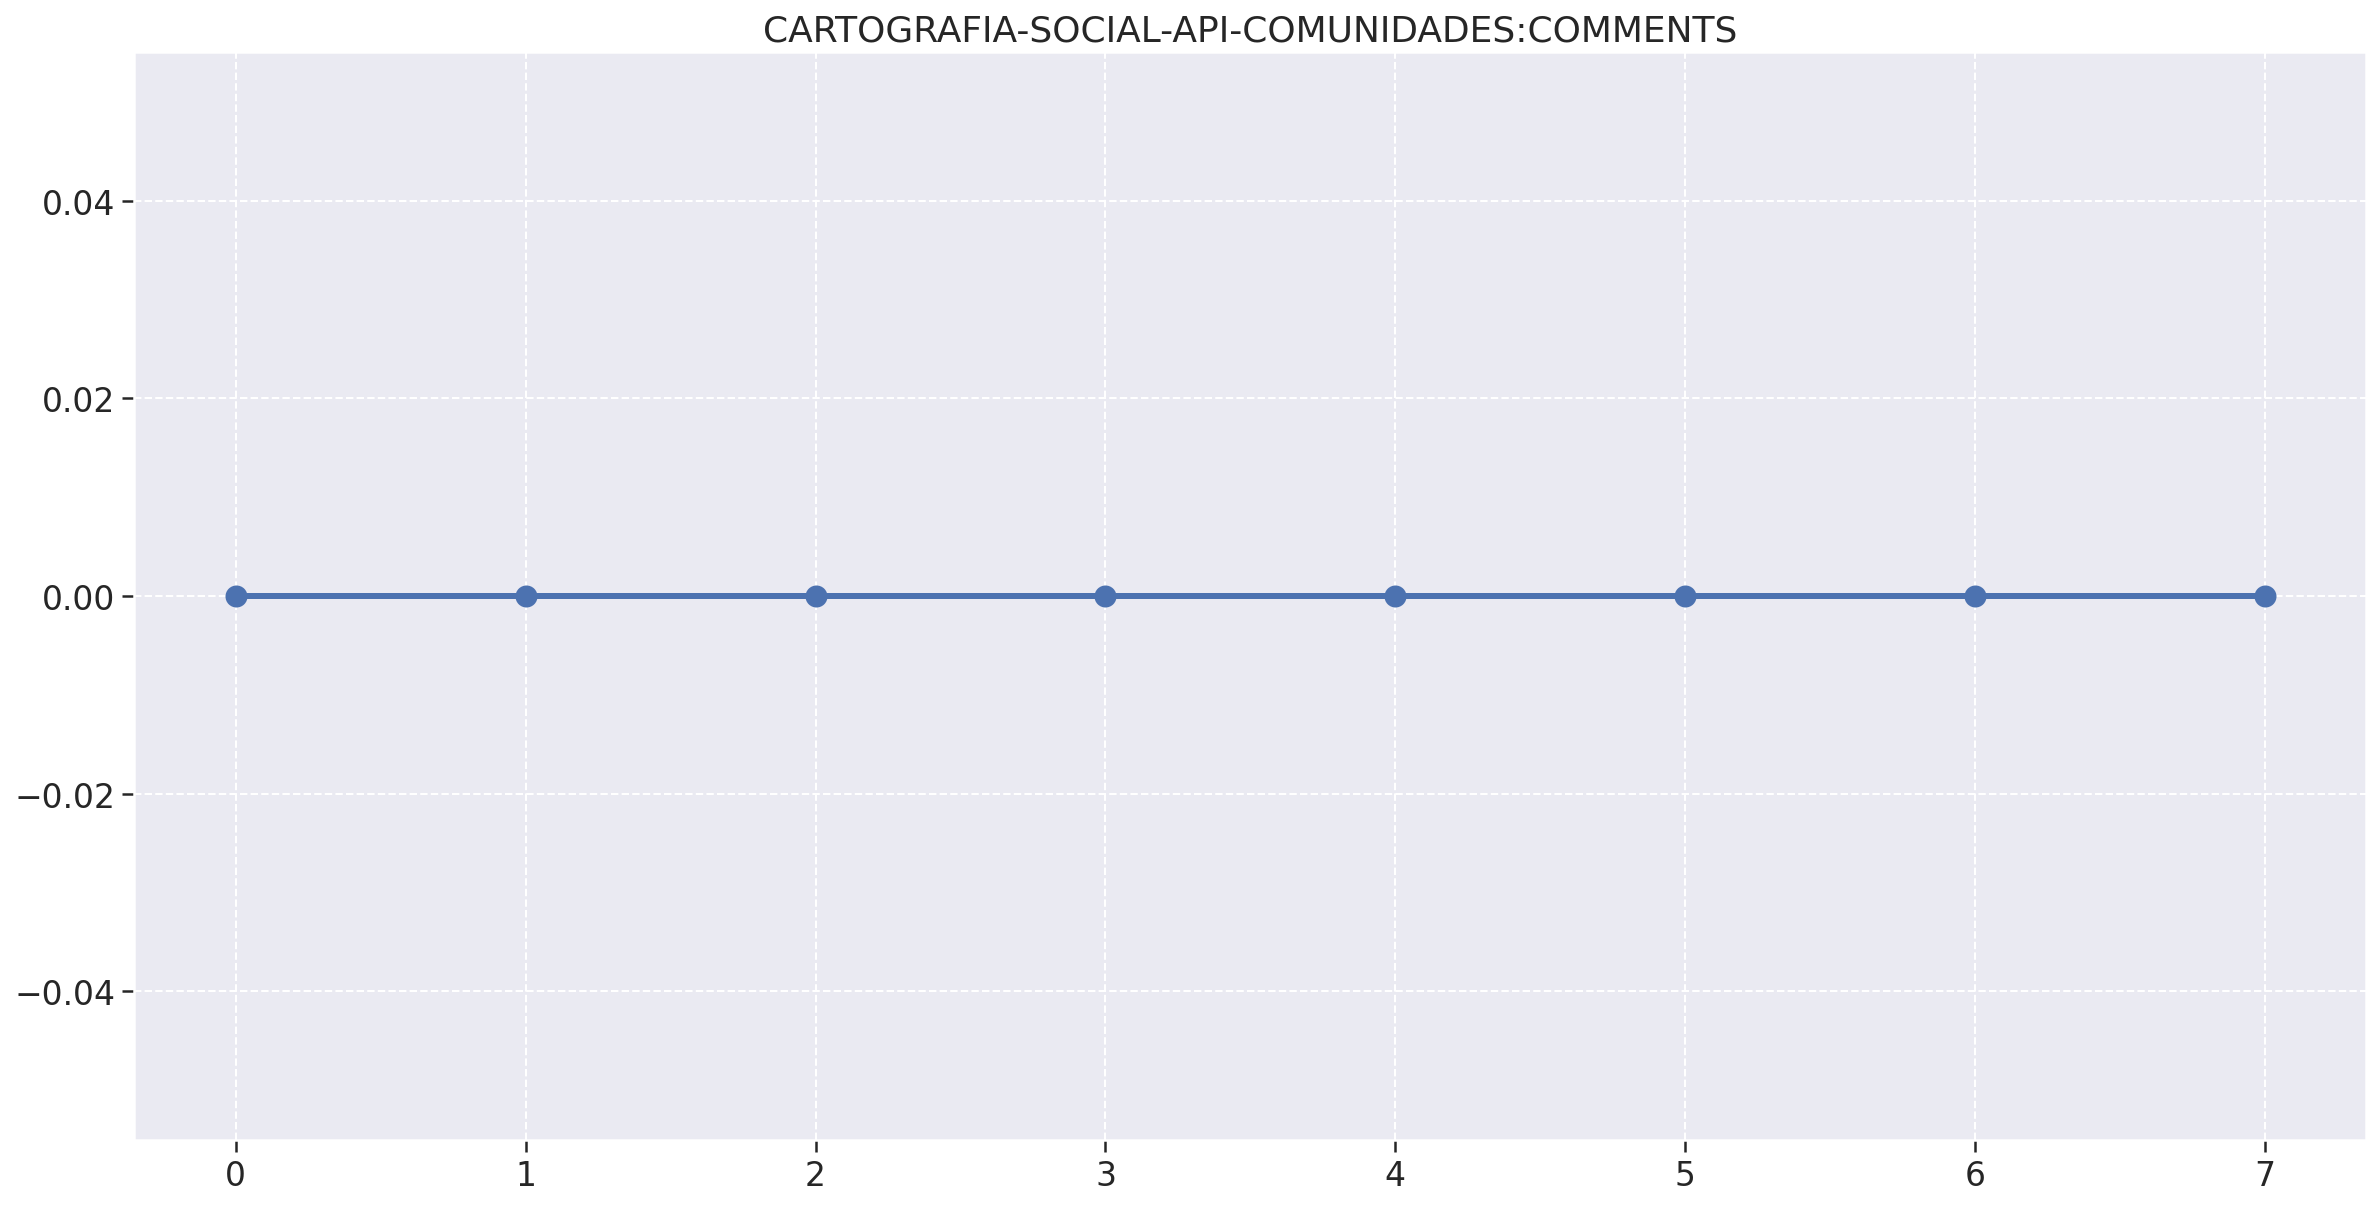

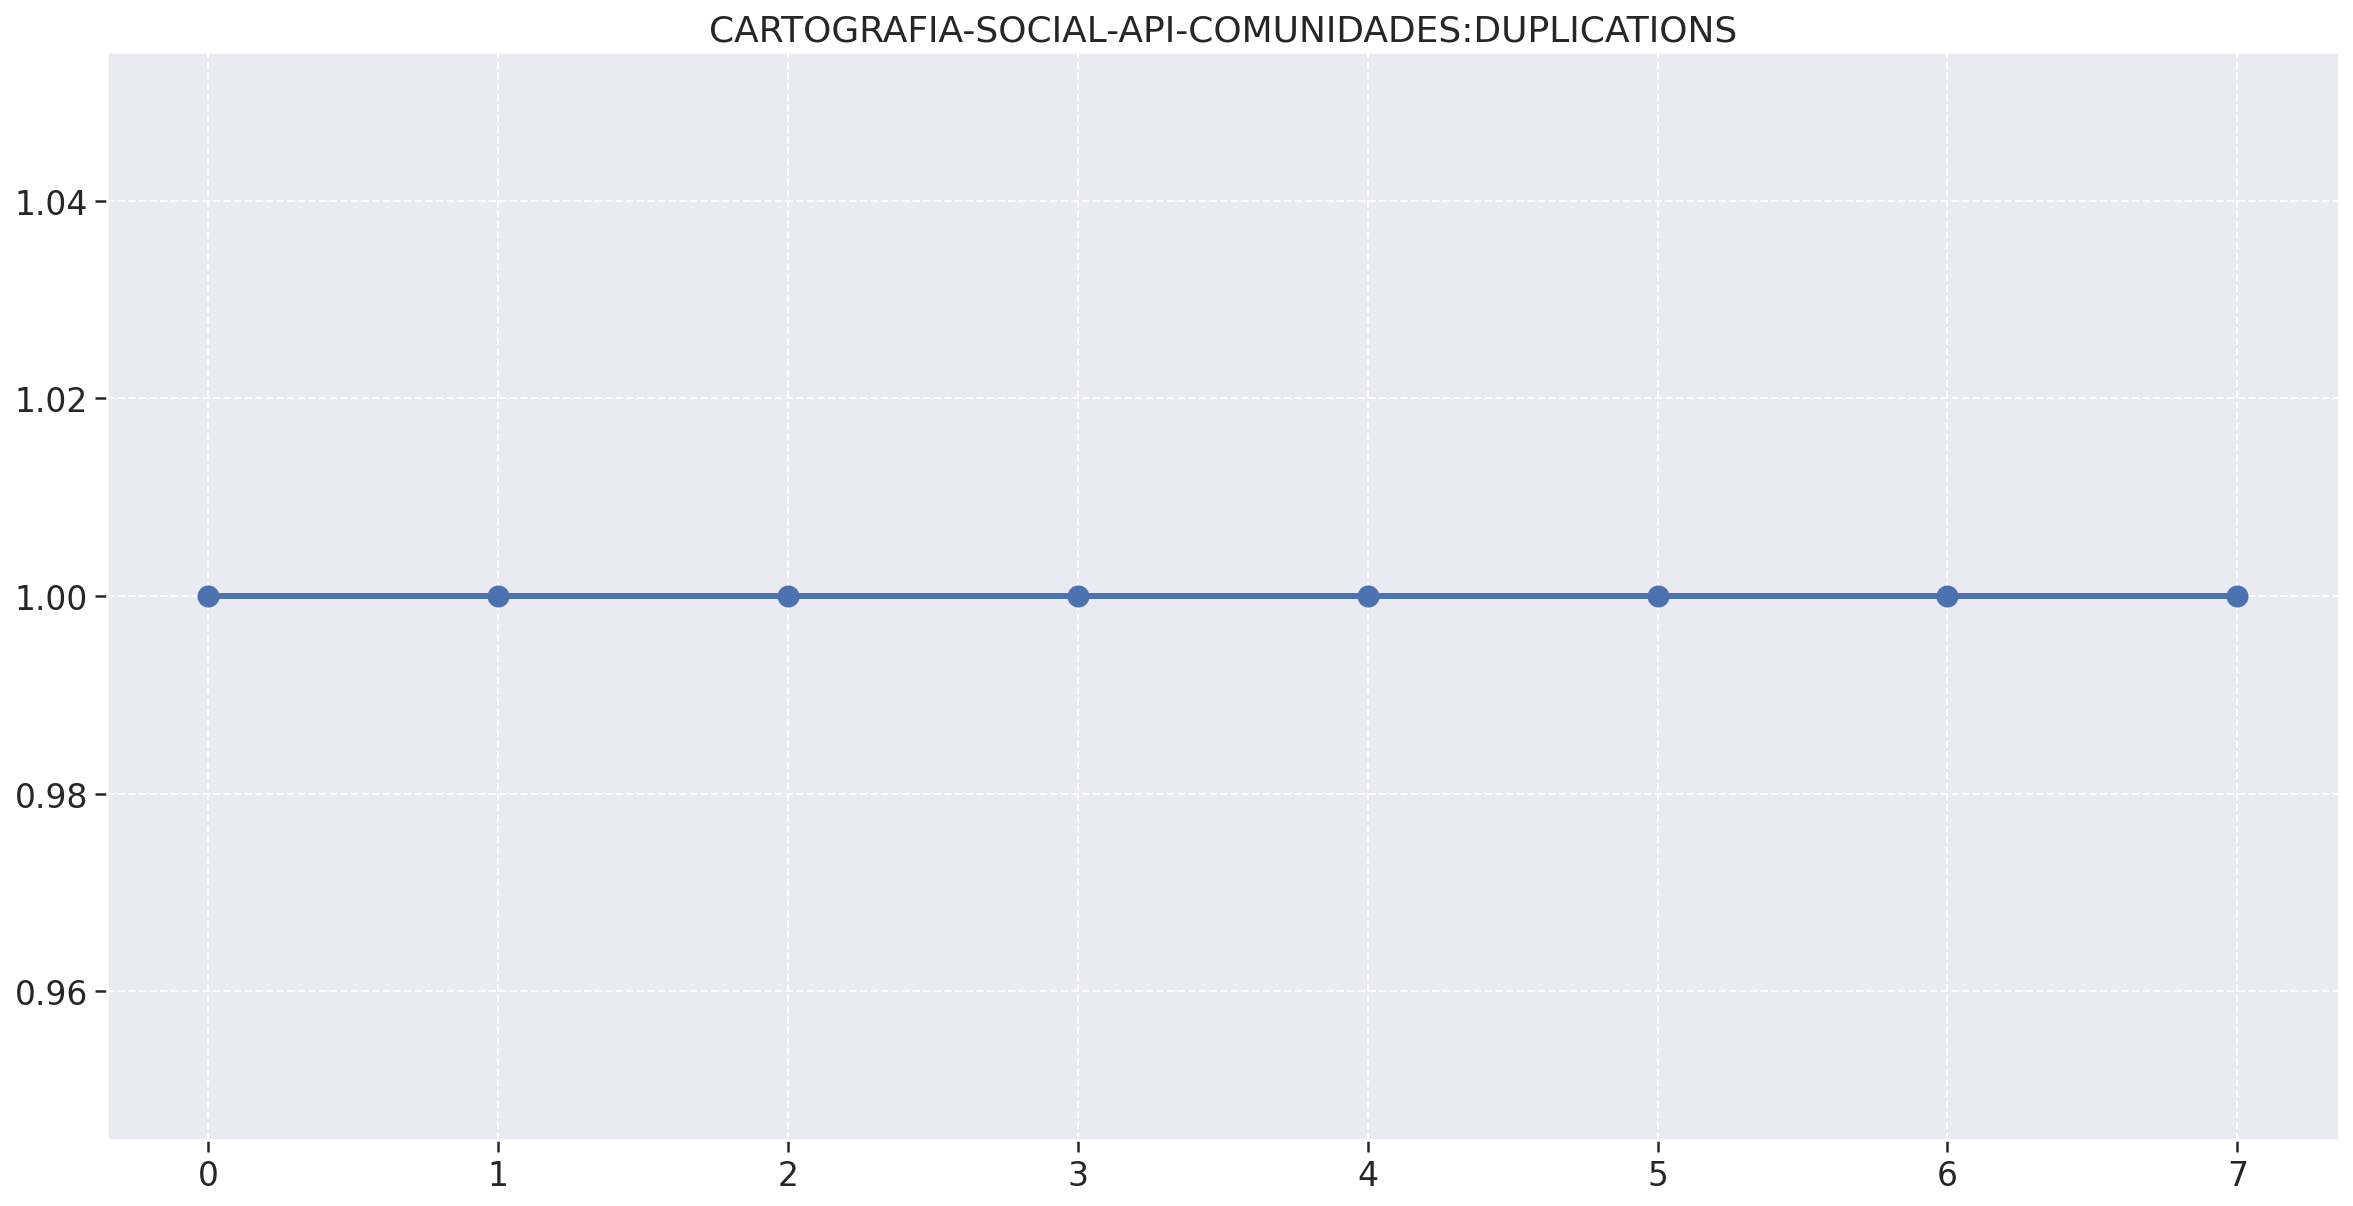

In [1750]:
plot_history(generic_df, repository)

### Estatistica descritiva - comunidades

In [1751]:
descriptive_statistics(generic_df)

,count,mean,std,min,25%,50%,75%,max,var,median
m1,8.0,0.620845,0.059756,0.52381,0.583333,0.6125,0.673077,0.692308,0.003571,0.6125
m2,8.0,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000
m3,8.0,1.000000,0.000000,1.00000,1.000000,1.0000,1.000000,1.000000,0.000000,1.0000
m4,8.0,1.000000,0.000000,1.00000,1.000000,1.0000,1.000000,1.000000,0.000000,1.0000
m5,8.0,1.000000,0.000000,1.00000,1.000000,1.0000,1.000000,1.000000,0.000000,1.0000
m6,8.0,1.000000,0.000000,1.00000,1.000000,1.0000,1.000000,1.000000,0.000000,1.0000
ncloc,8.0,333.250000,118.426288,161.00000,262.000000,335.0000,414.750000,482.000000,14024.785714,335.0000


### Cálculo da moda - comunidades

In [1752]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc
0,0.583333,0.0,1.0,1.0,1.0,1.0,161
1,0.692308,NaN,NaN,NaN,NaN,NaN,196
2,NaN,NaN,NaN,NaN,NaN,NaN,284
3,NaN,NaN,NaN,NaN,NaN,NaN,334
4,NaN,NaN,NaN,NaN,NaN,NaN,336
5,NaN,NaN,NaN,NaN,NaN,NaN,393
6,NaN,NaN,NaN,NaN,NaN,NaN,480
7,NaN,NaN,NaN,NaN,NaN,NaN,482


### Tabela de porcentagem - comunidades

In [1753]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc
0%,0.523810,0.0,1.0,1.0,1.0,1.0,161.00
10%,0.565476,0.0,1.0,1.0,1.0,1.0,185.50
20%,0.583333,0.0,1.0,1.0,1.0,1.0,231.20
30%,0.585000,0.0,1.0,1.0,1.0,1.0,289.00
40%,0.596667,0.0,1.0,1.0,1.0,1.0,324.00
50%,0.612500,0.0,1.0,1.0,1.0,1.0,335.00
60%,0.633333,0.0,1.0,1.0,1.0,1.0,347.40
70%,0.662500,0.0,1.0,1.0,1.0,1.0,387.30
80%,0.682051,0.0,1.0,1.0,1.0,1.0,445.20
99%,0.692308,0.0,1.0,1.0,1.0,1.0,481.86


### Matriz de correlação - comunidades

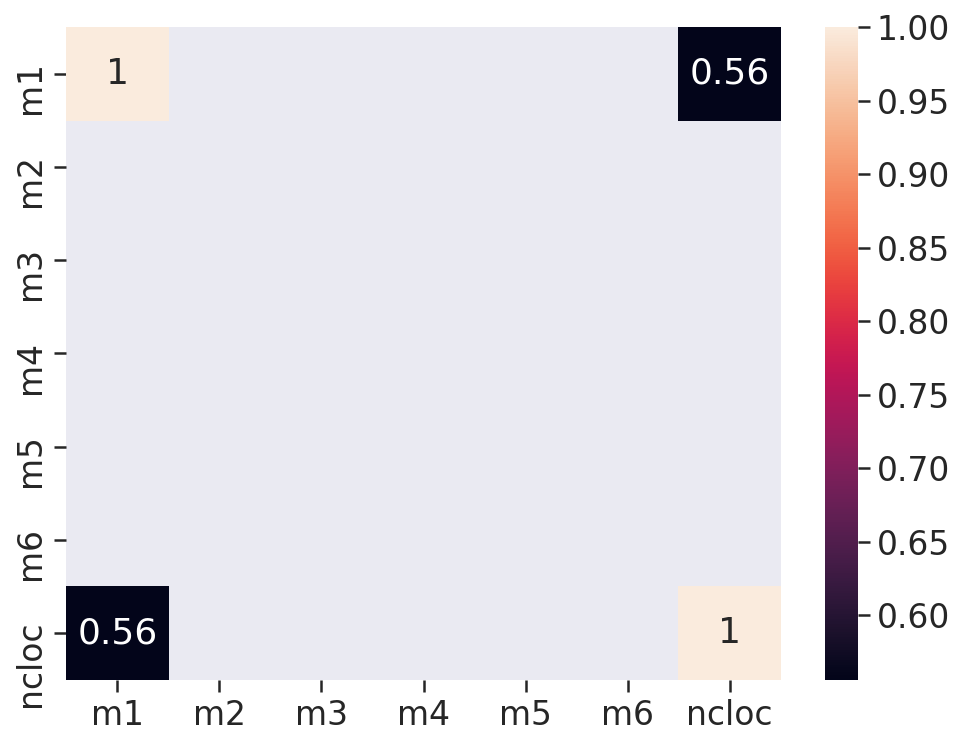

In [1754]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Box-plot - comunidades

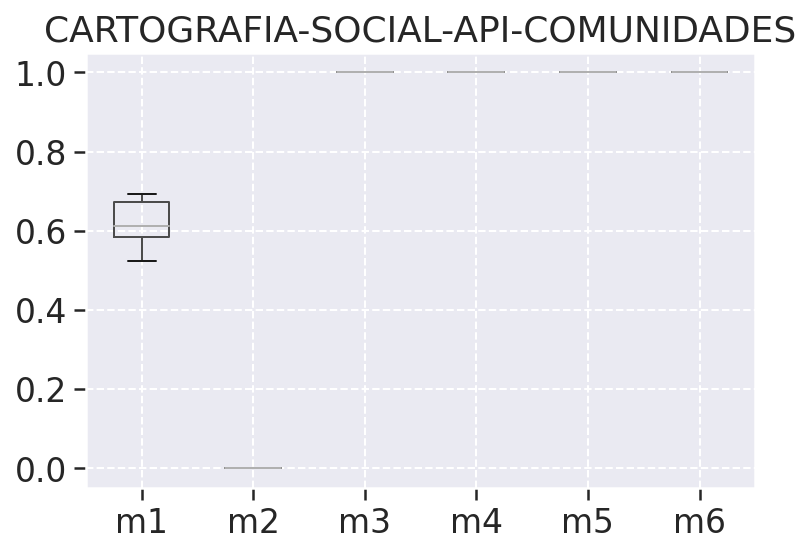

In [1755]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-gateway

In [1756]:
generic_df = api_gateway_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-GATEWAY"

### Plot do Histórico das métricas - gateway

In [1757]:
#plot_history(generic_df, repository)

### Estatistica descritiva - Gateway

In [1758]:
descriptive_statistics(generic_df)

,count,mean,std,min,25%,50%,75%,max,var,median
m1,13.0,0.465000,0.215268,0.250000,0.357143,0.384615,0.500000,1.000000,0.046340,0.384615
m2,13.0,0.064937,0.054408,0.000000,0.000000,0.071429,0.083333,0.166667,0.002960,0.071429
m3,13.0,0.988604,0.027817,0.925926,1.000000,1.000000,1.000000,1.000000,0.000774,1.000000
m4,13.0,0.988604,0.027817,0.925926,1.000000,1.000000,1.000000,1.000000,0.000774,1.000000
m5,13.0,0.988604,0.027817,0.925926,1.000000,1.000000,1.000000,1.000000,0.000774,1.000000
m6,13.0,0.988604,0.027817,0.925926,1.000000,1.000000,1.000000,1.000000,0.000774,1.000000
ncloc,13.0,427.692308,303.887969,46.000000,239.000000,367.000000,462.000000,1031.000000,92347.897436,367.000000


### Cálculo da moda - Gateway

In [1759]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc
0,0.250000,0.0,1.0,1.0,1.0,1.0,367.0
1,0.375000,NaN,NaN,NaN,NaN,NaN,1031.0
2,0.416667,NaN,NaN,NaN,NaN,NaN,NaN
3,0.703704,NaN,NaN,NaN,NaN,NaN,NaN


### Tabela de porcentagem - Gateway

In [1760]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc
0%,0.250000,0.000000,0.925926,0.925926,0.925926,0.925926,46.0
10%,0.262500,0.000000,0.940741,0.940741,0.940741,0.940741,133.6
20%,0.330357,0.000000,1.000000,1.000000,1.000000,1.000000,206.0
30%,0.367857,0.030000,1.000000,1.000000,1.000000,1.000000,264.8
40%,0.375000,0.060000,1.000000,1.000000,1.000000,1.000000,350.0
50%,0.384615,0.071429,1.000000,1.000000,1.000000,1.000000,367.0
60%,0.416667,0.078205,1.000000,1.000000,1.000000,1.000000,433.2
70%,0.450000,0.083333,1.000000,1.000000,1.000000,1.000000,454.8
80%,0.622222,0.108333,1.000000,1.000000,1.000000,1.000000,515.4
99%,0.964444,0.161667,1.000000,1.000000,1.000000,1.000000,1031.0


### Matriz de correlação - Gateway

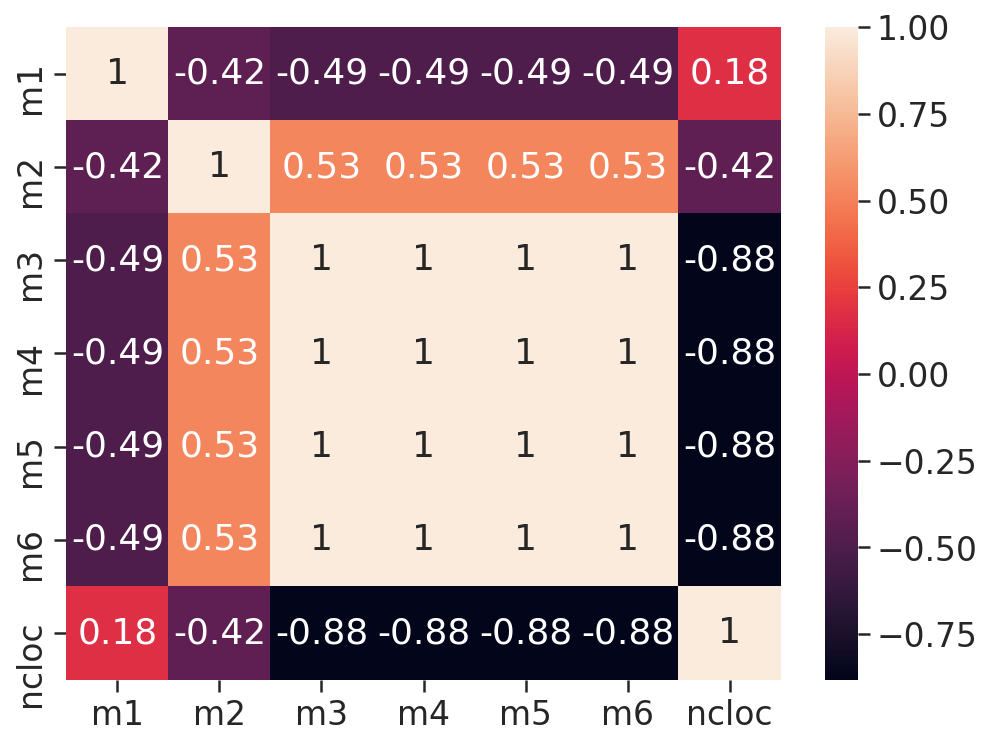

In [1761]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Box-plot - Gateway

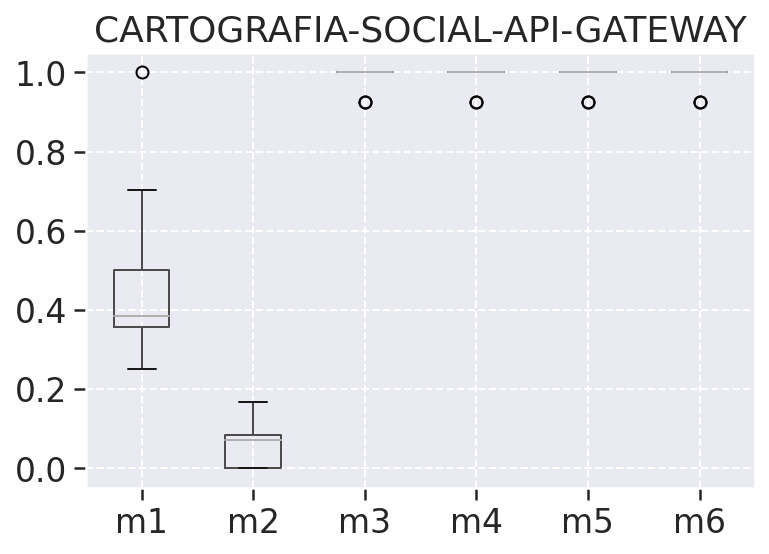

In [1762]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-mapas


In [1763]:
generic_df = api_mapas_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-MAPAS"

### Plot do Histórico das métricas - mapas

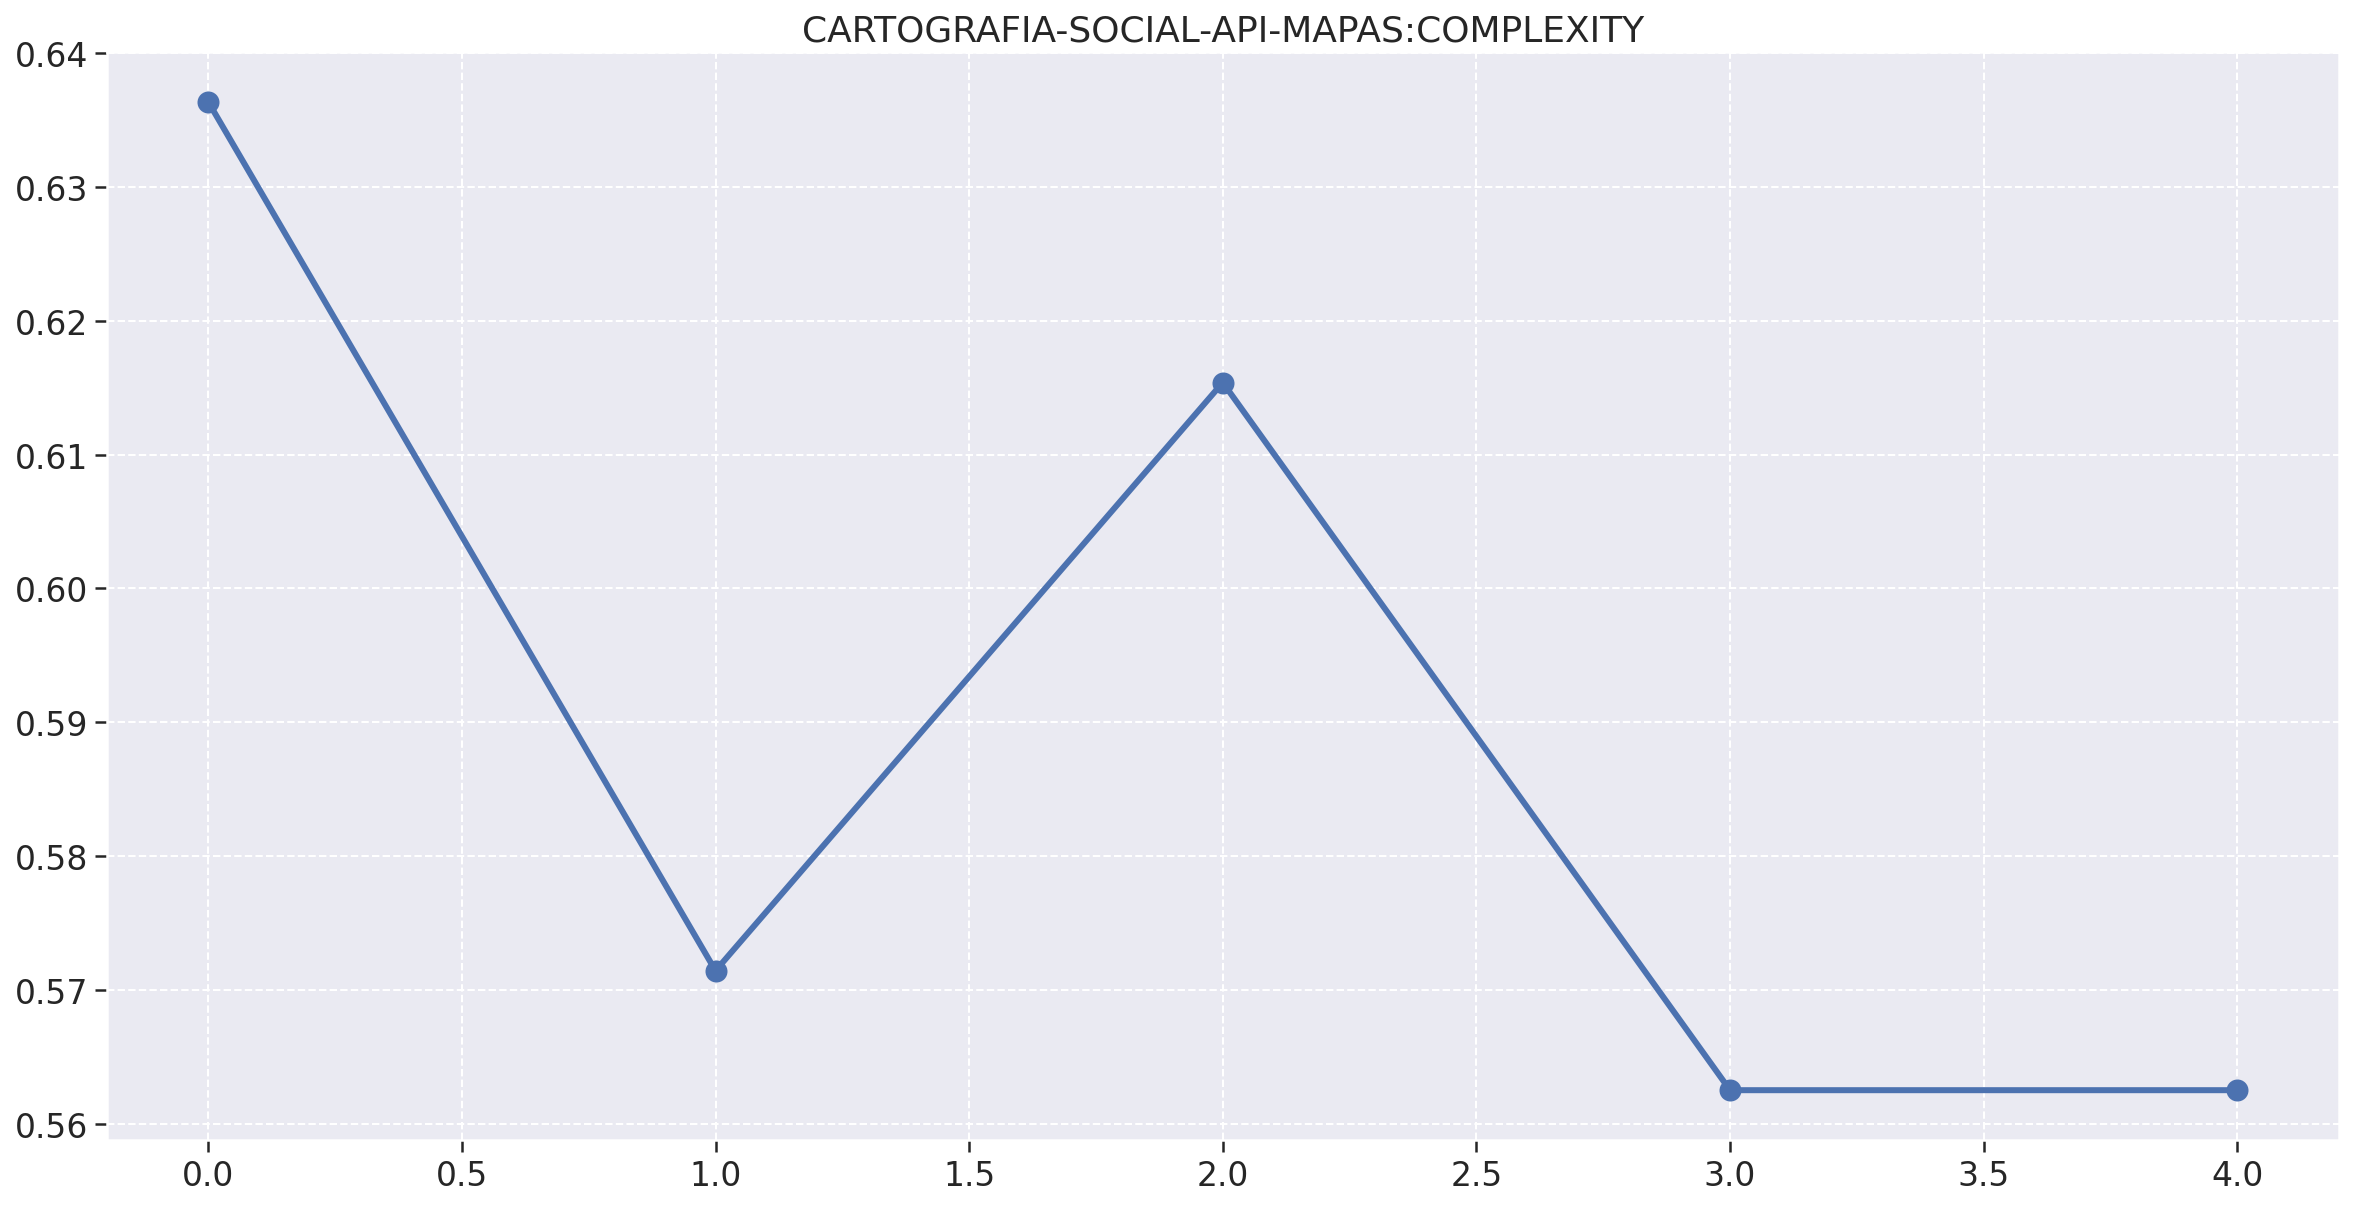

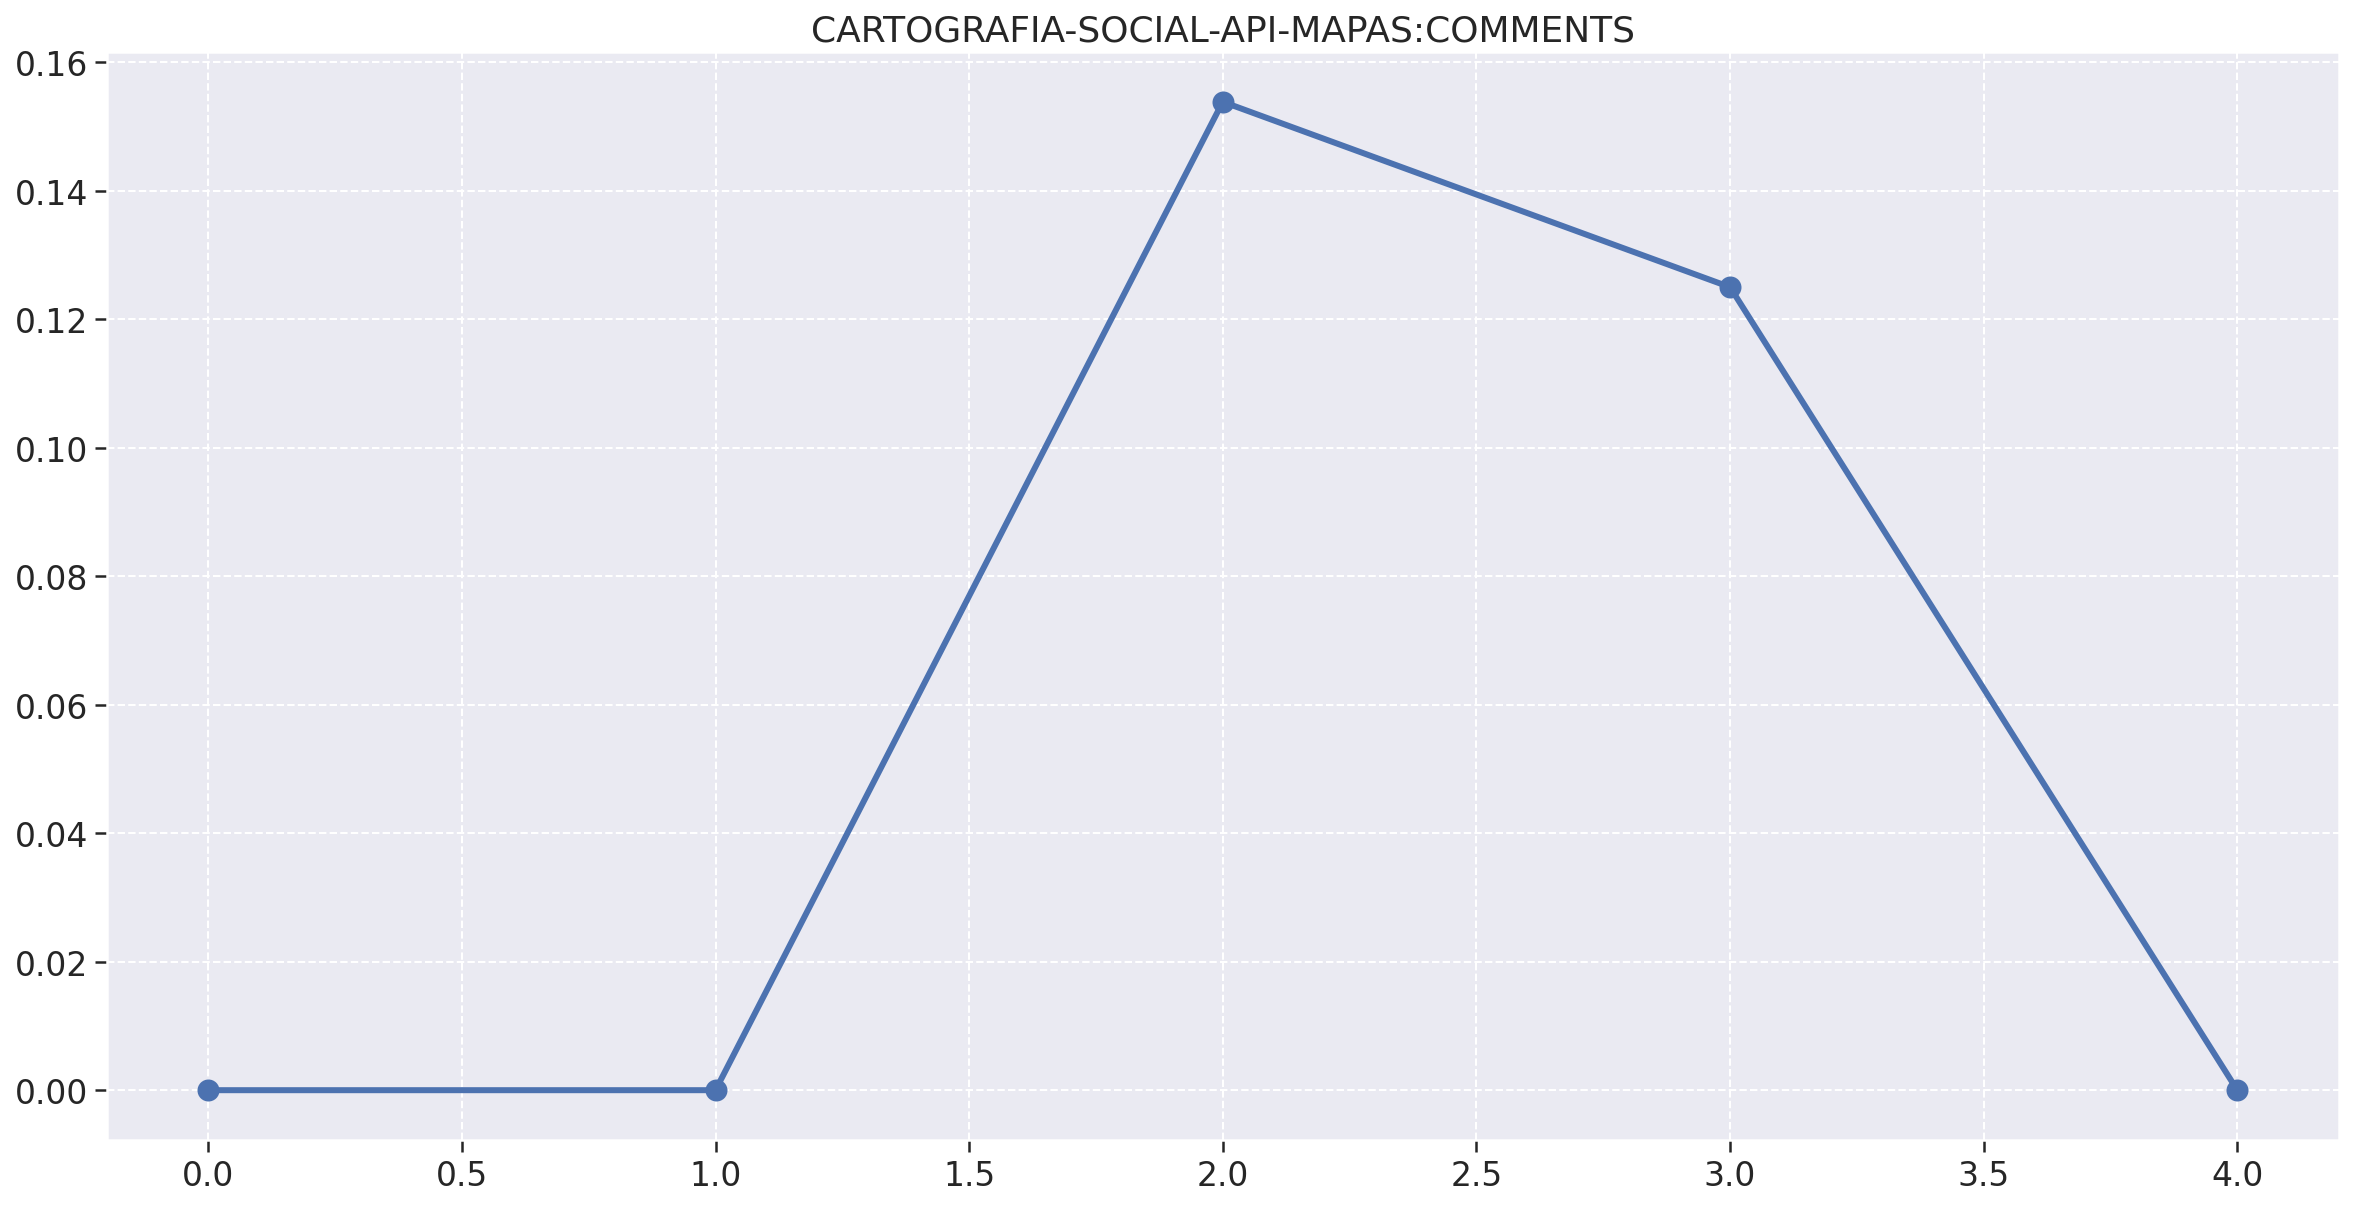

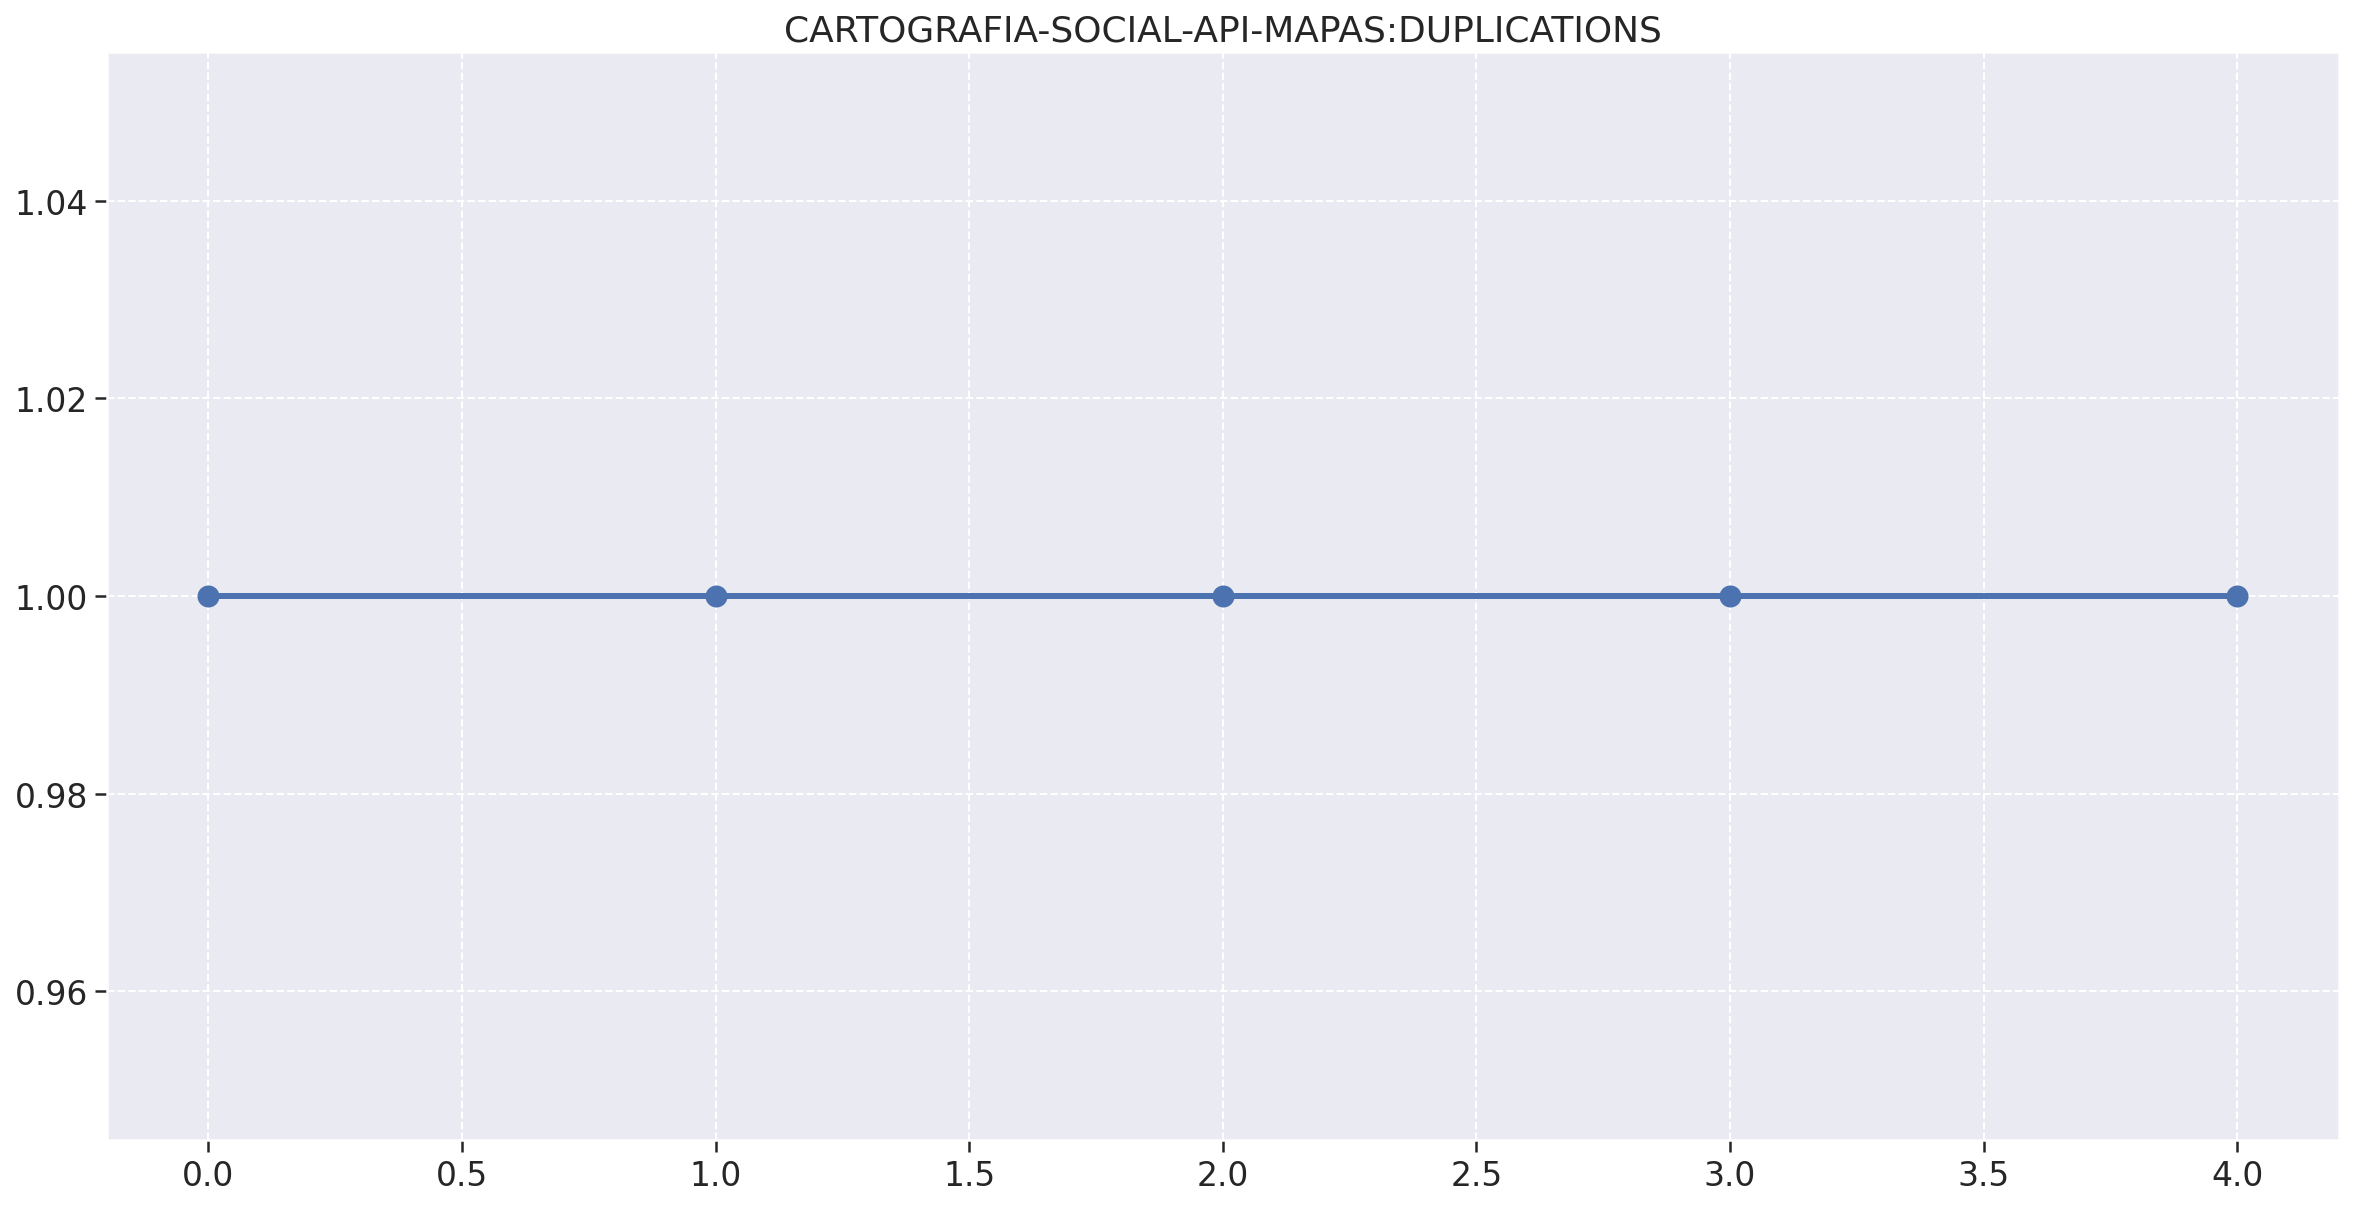

In [1764]:
plot_history(generic_df, repository)

### Estatistica descritiva - mapas

In [1765]:
descriptive_statistics(generic_df)

,count,mean,std,min,25%,50%,75%,max,var,median
m1,5.0,0.589635,0.034098,0.5625,0.5625,0.571429,0.615385,0.636364,0.001163,0.571429
m2,5.0,0.055769,0.077043,0.0000,0.0000,0.000000,0.125000,0.153846,0.005936,0.000000
m3,5.0,1.000000,0.000000,1.0000,1.0000,1.000000,1.000000,1.000000,0.000000,1.000000
m4,5.0,1.000000,0.000000,1.0000,1.0000,1.000000,1.000000,1.000000,0.000000,1.000000
m5,5.0,1.000000,0.000000,1.0000,1.0000,1.000000,1.000000,1.000000,0.000000,1.000000
m6,5.0,1.000000,0.000000,1.0000,1.0000,1.000000,1.000000,1.000000,0.000000,1.000000
ncloc,5.0,383.200000,185.587446,167.0000,214.0000,419.000000,556.000000,560.000000,34442.700000,419.000000


### Cálculo da moda - mapas

In [1766]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc
0,0.5625,0.0,1.0,1.0,1.0,1.0,167
1,NaN,NaN,NaN,NaN,NaN,NaN,214
2,NaN,NaN,NaN,NaN,NaN,NaN,419
3,NaN,NaN,NaN,NaN,NaN,NaN,556
4,NaN,NaN,NaN,NaN,NaN,NaN,560


### Tabela de percentis - mapas

In [1767]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc
0%,0.562500,0.000000,1.0,1.0,1.0,1.0,167.00
10%,0.562500,0.000000,1.0,1.0,1.0,1.0,185.80
20%,0.562500,0.000000,1.0,1.0,1.0,1.0,204.60
30%,0.564286,0.000000,1.0,1.0,1.0,1.0,255.00
40%,0.567857,0.000000,1.0,1.0,1.0,1.0,337.00
50%,0.571429,0.000000,1.0,1.0,1.0,1.0,419.00
60%,0.589011,0.050000,1.0,1.0,1.0,1.0,473.80
70%,0.606593,0.100000,1.0,1.0,1.0,1.0,528.60
80%,0.619580,0.130769,1.0,1.0,1.0,1.0,556.80
99%,0.635524,0.152692,1.0,1.0,1.0,1.0,559.84


### Matriz de correlação - mapas

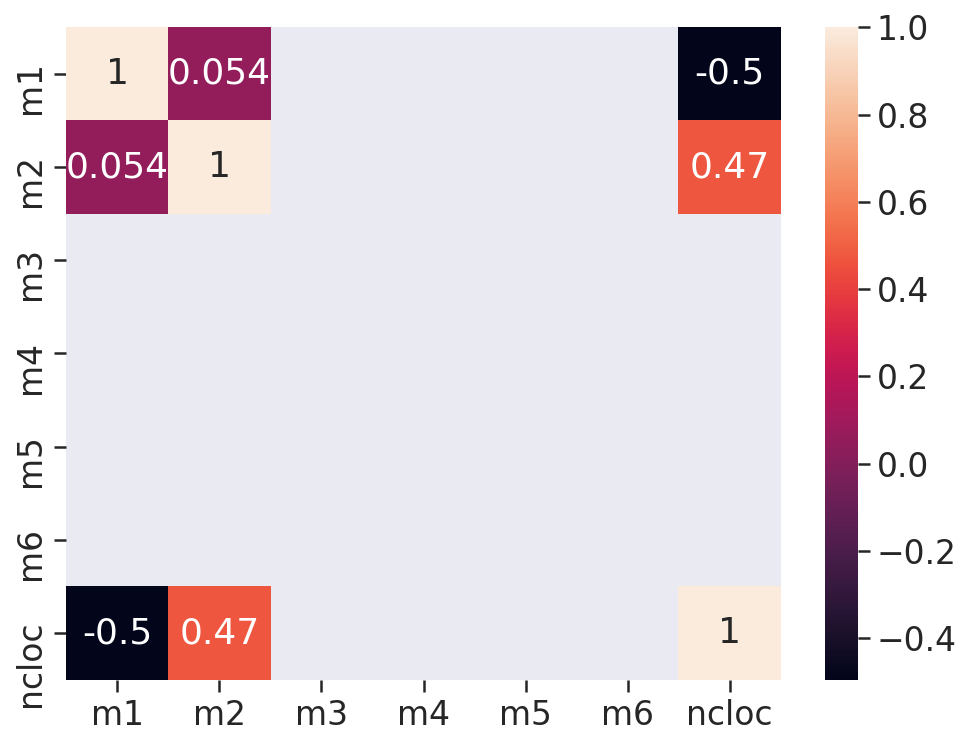

In [1768]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Box-plot - Mapas

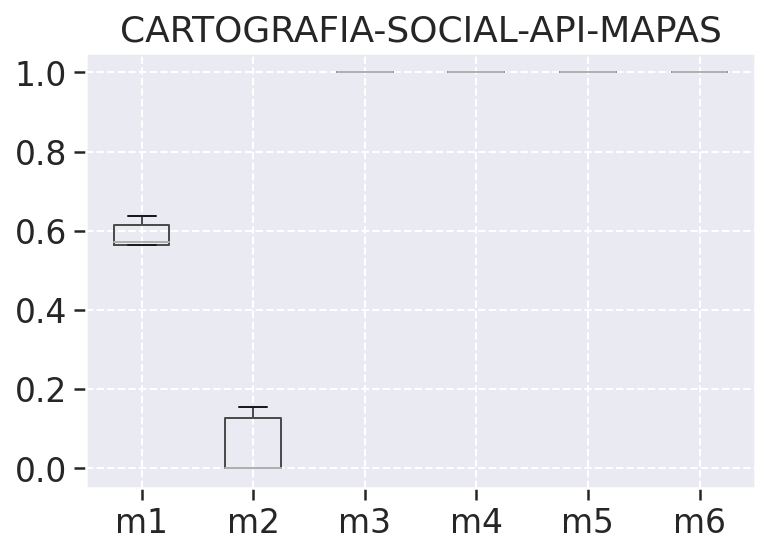

In [1769]:
generate_box(generic_df, repository)
#generic_df

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-midia


In [1770]:
generic_df = api_midia_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-MIDIA"

### Plot do Histórico das métricas - midia

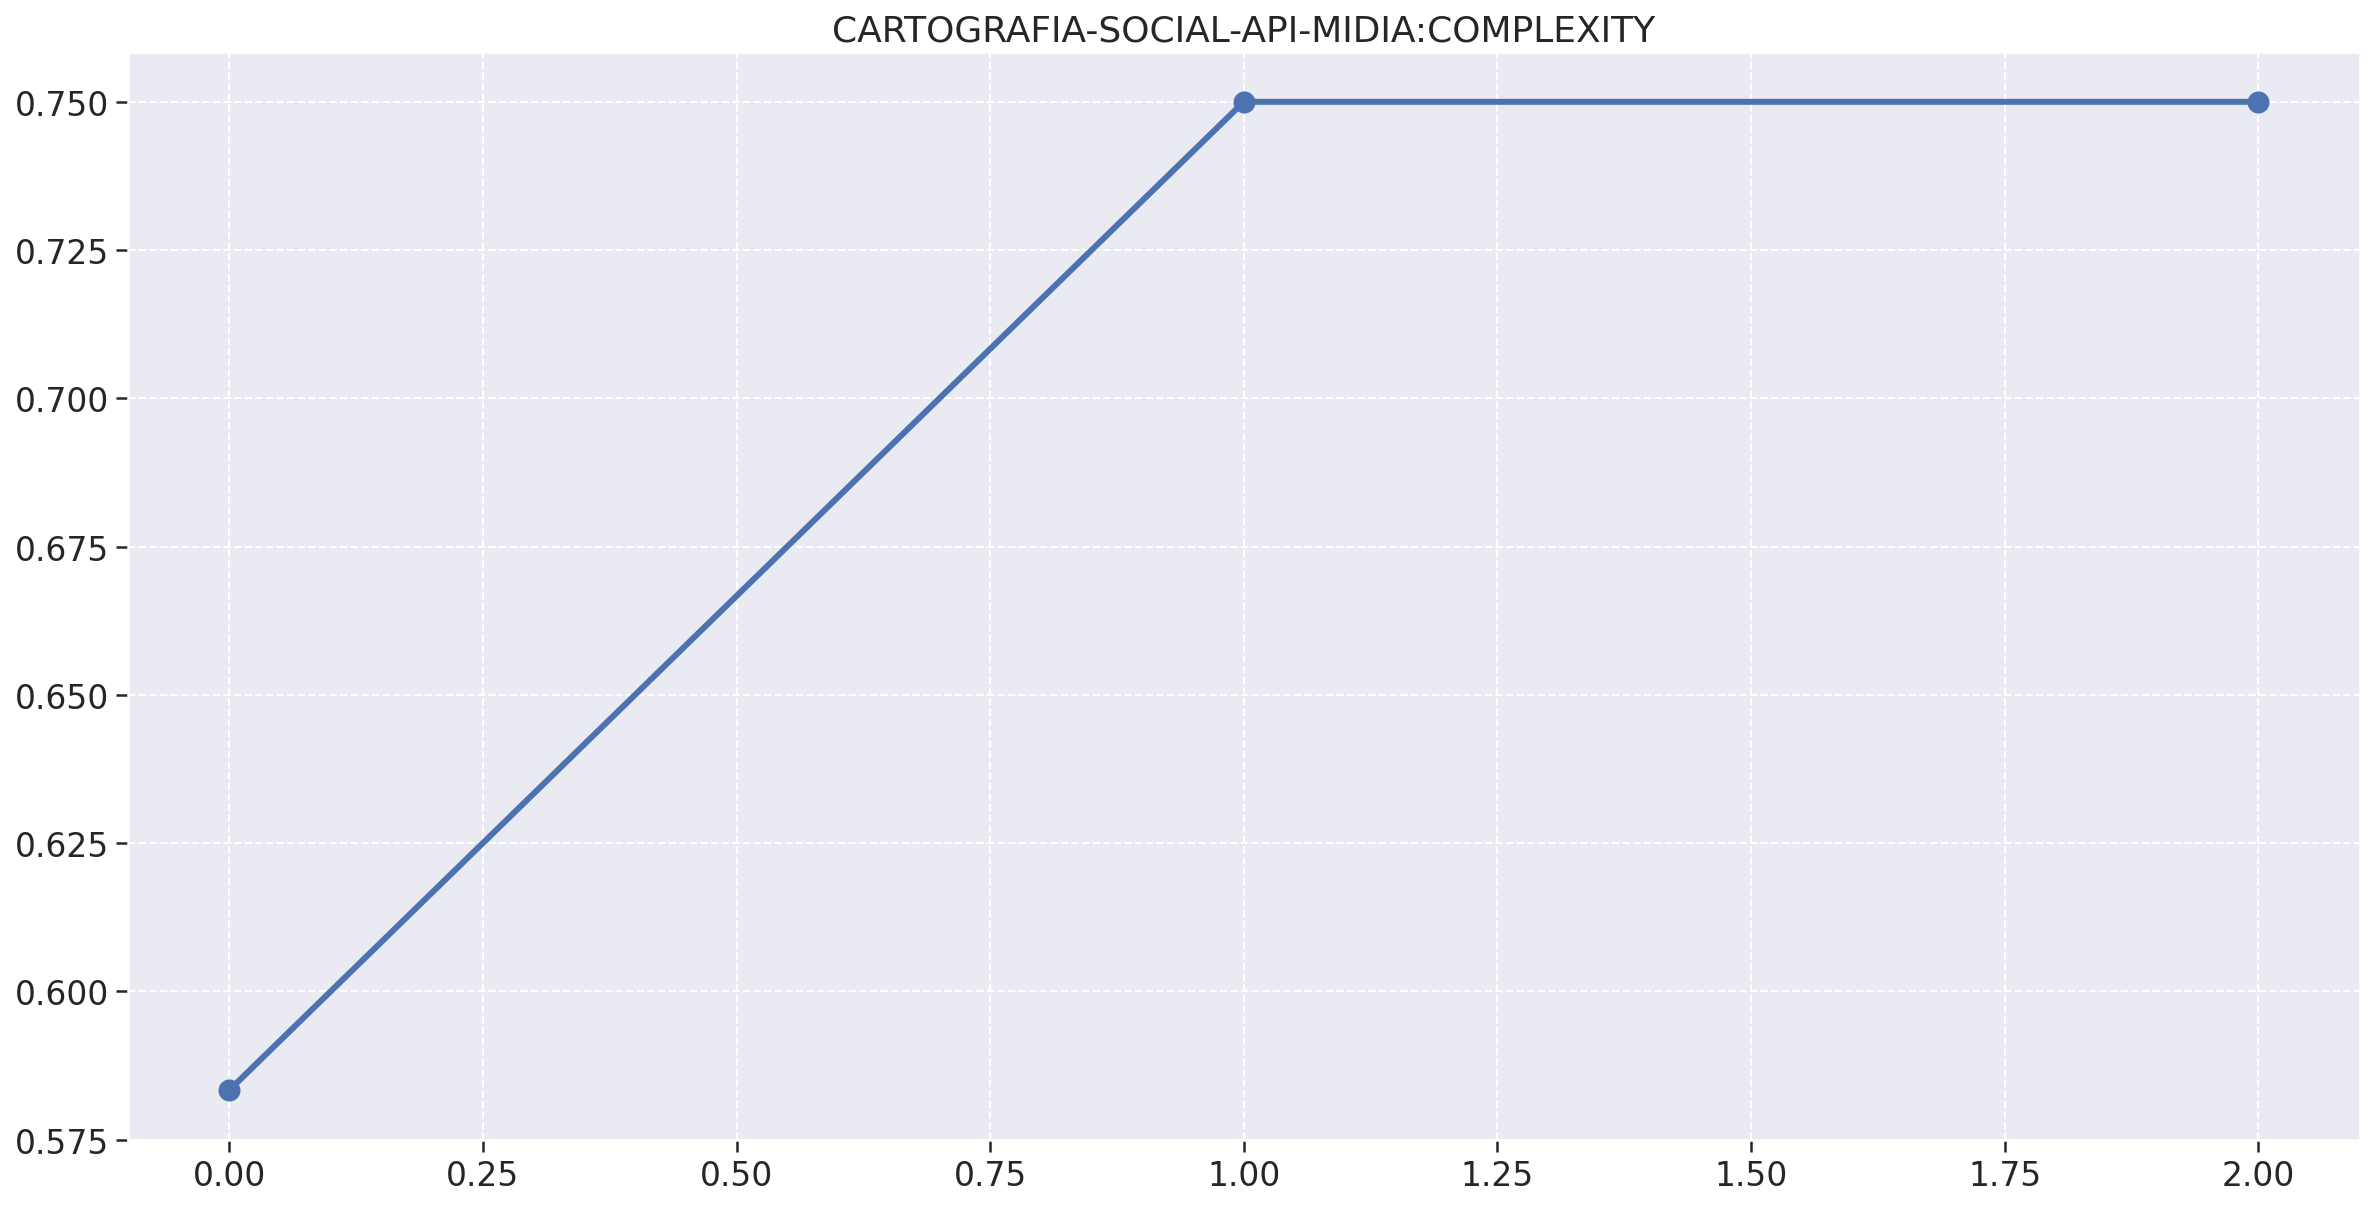

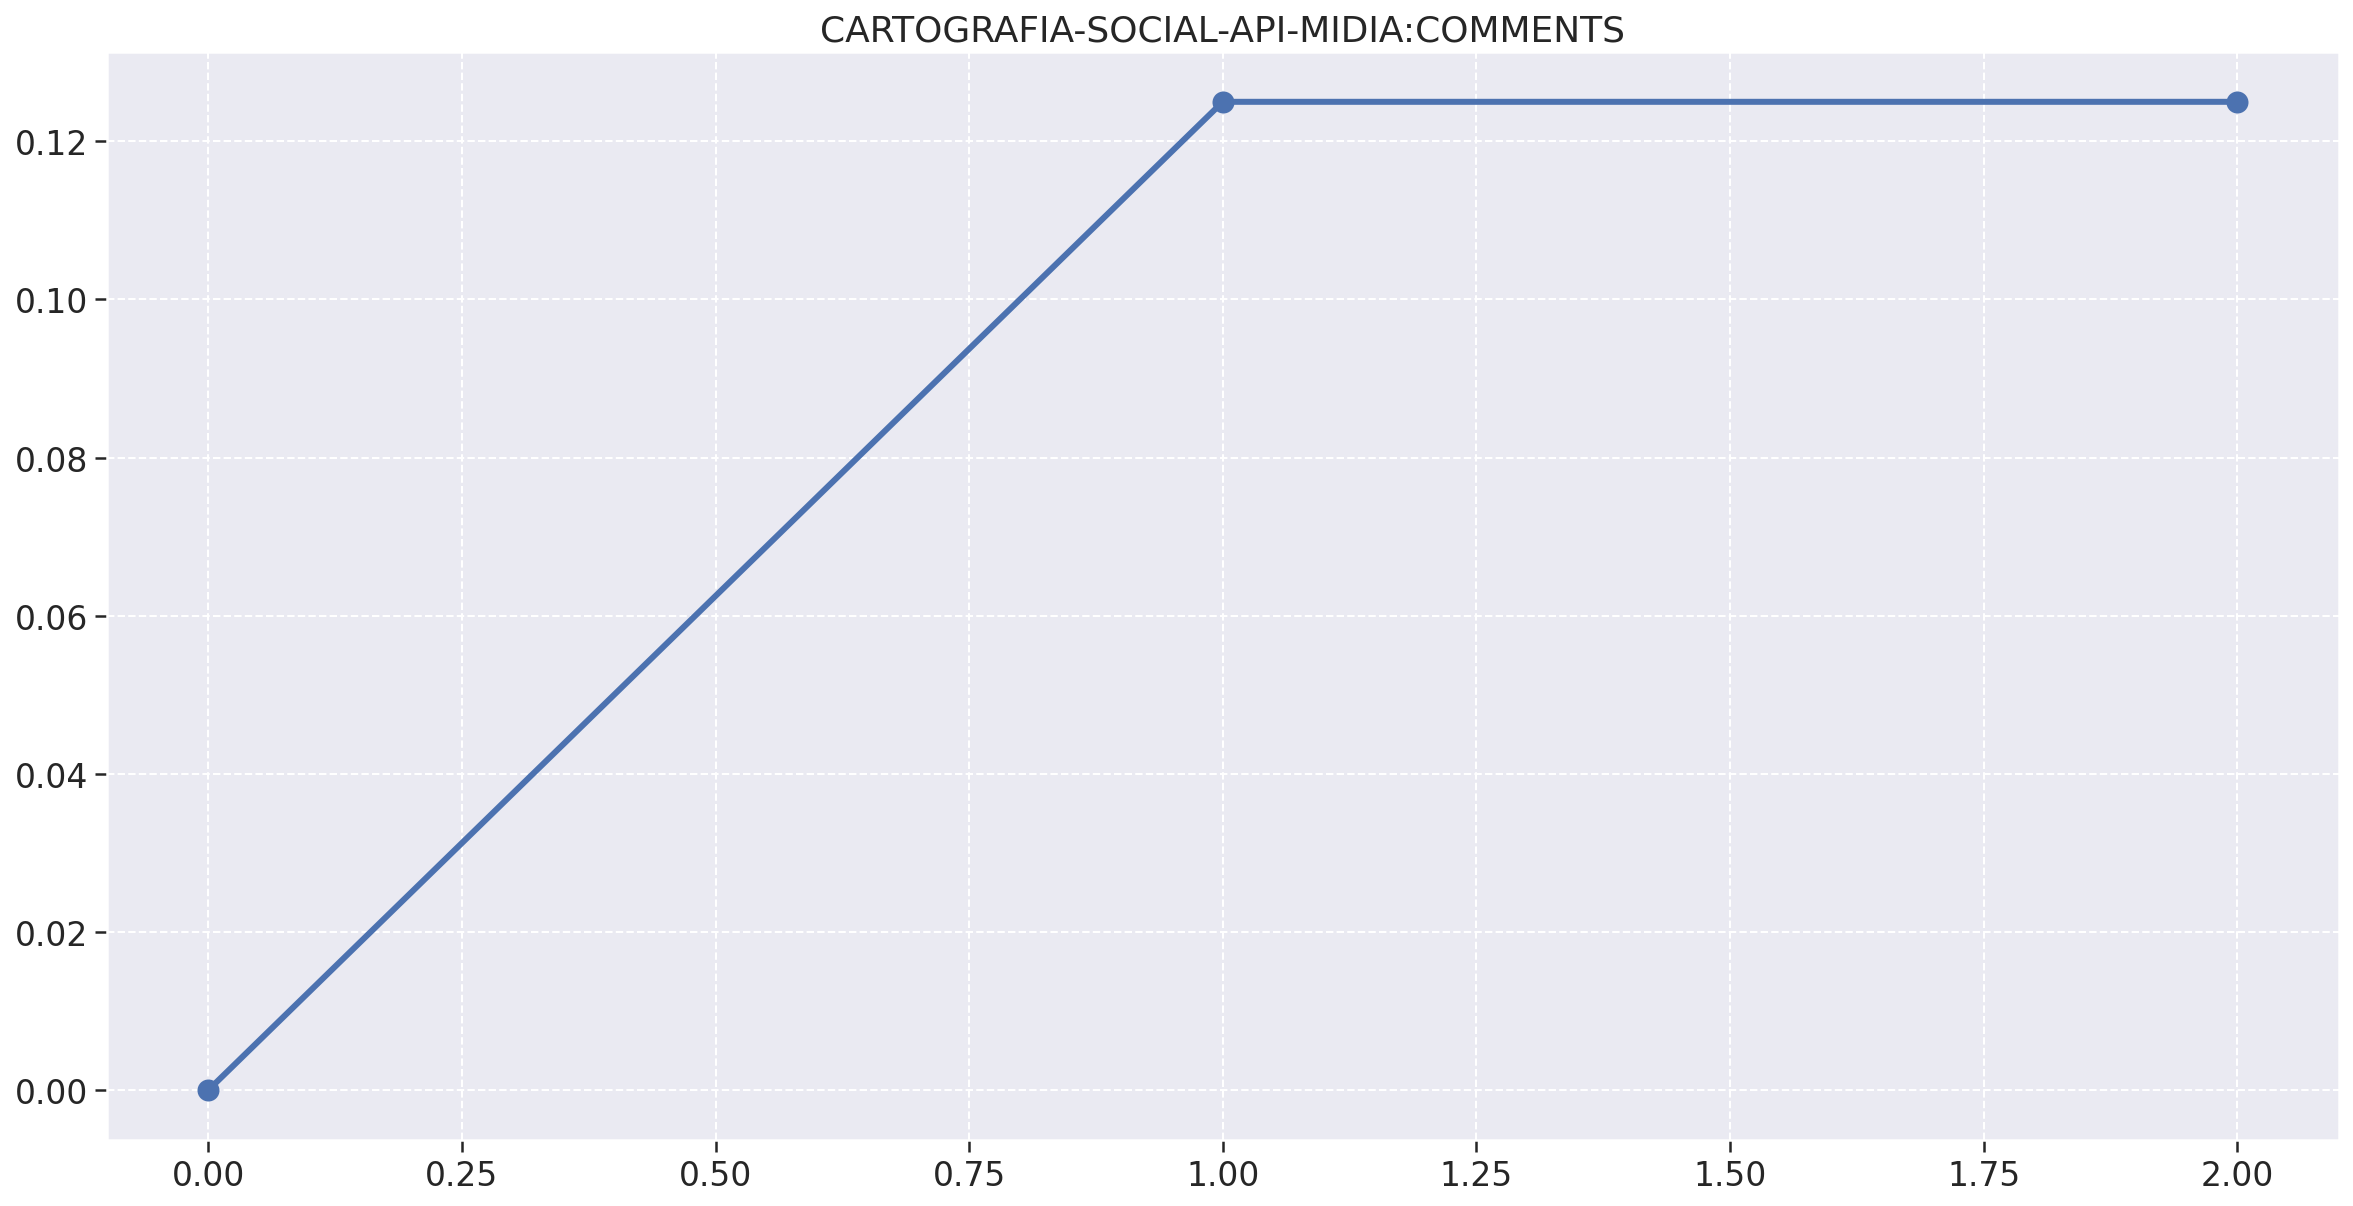

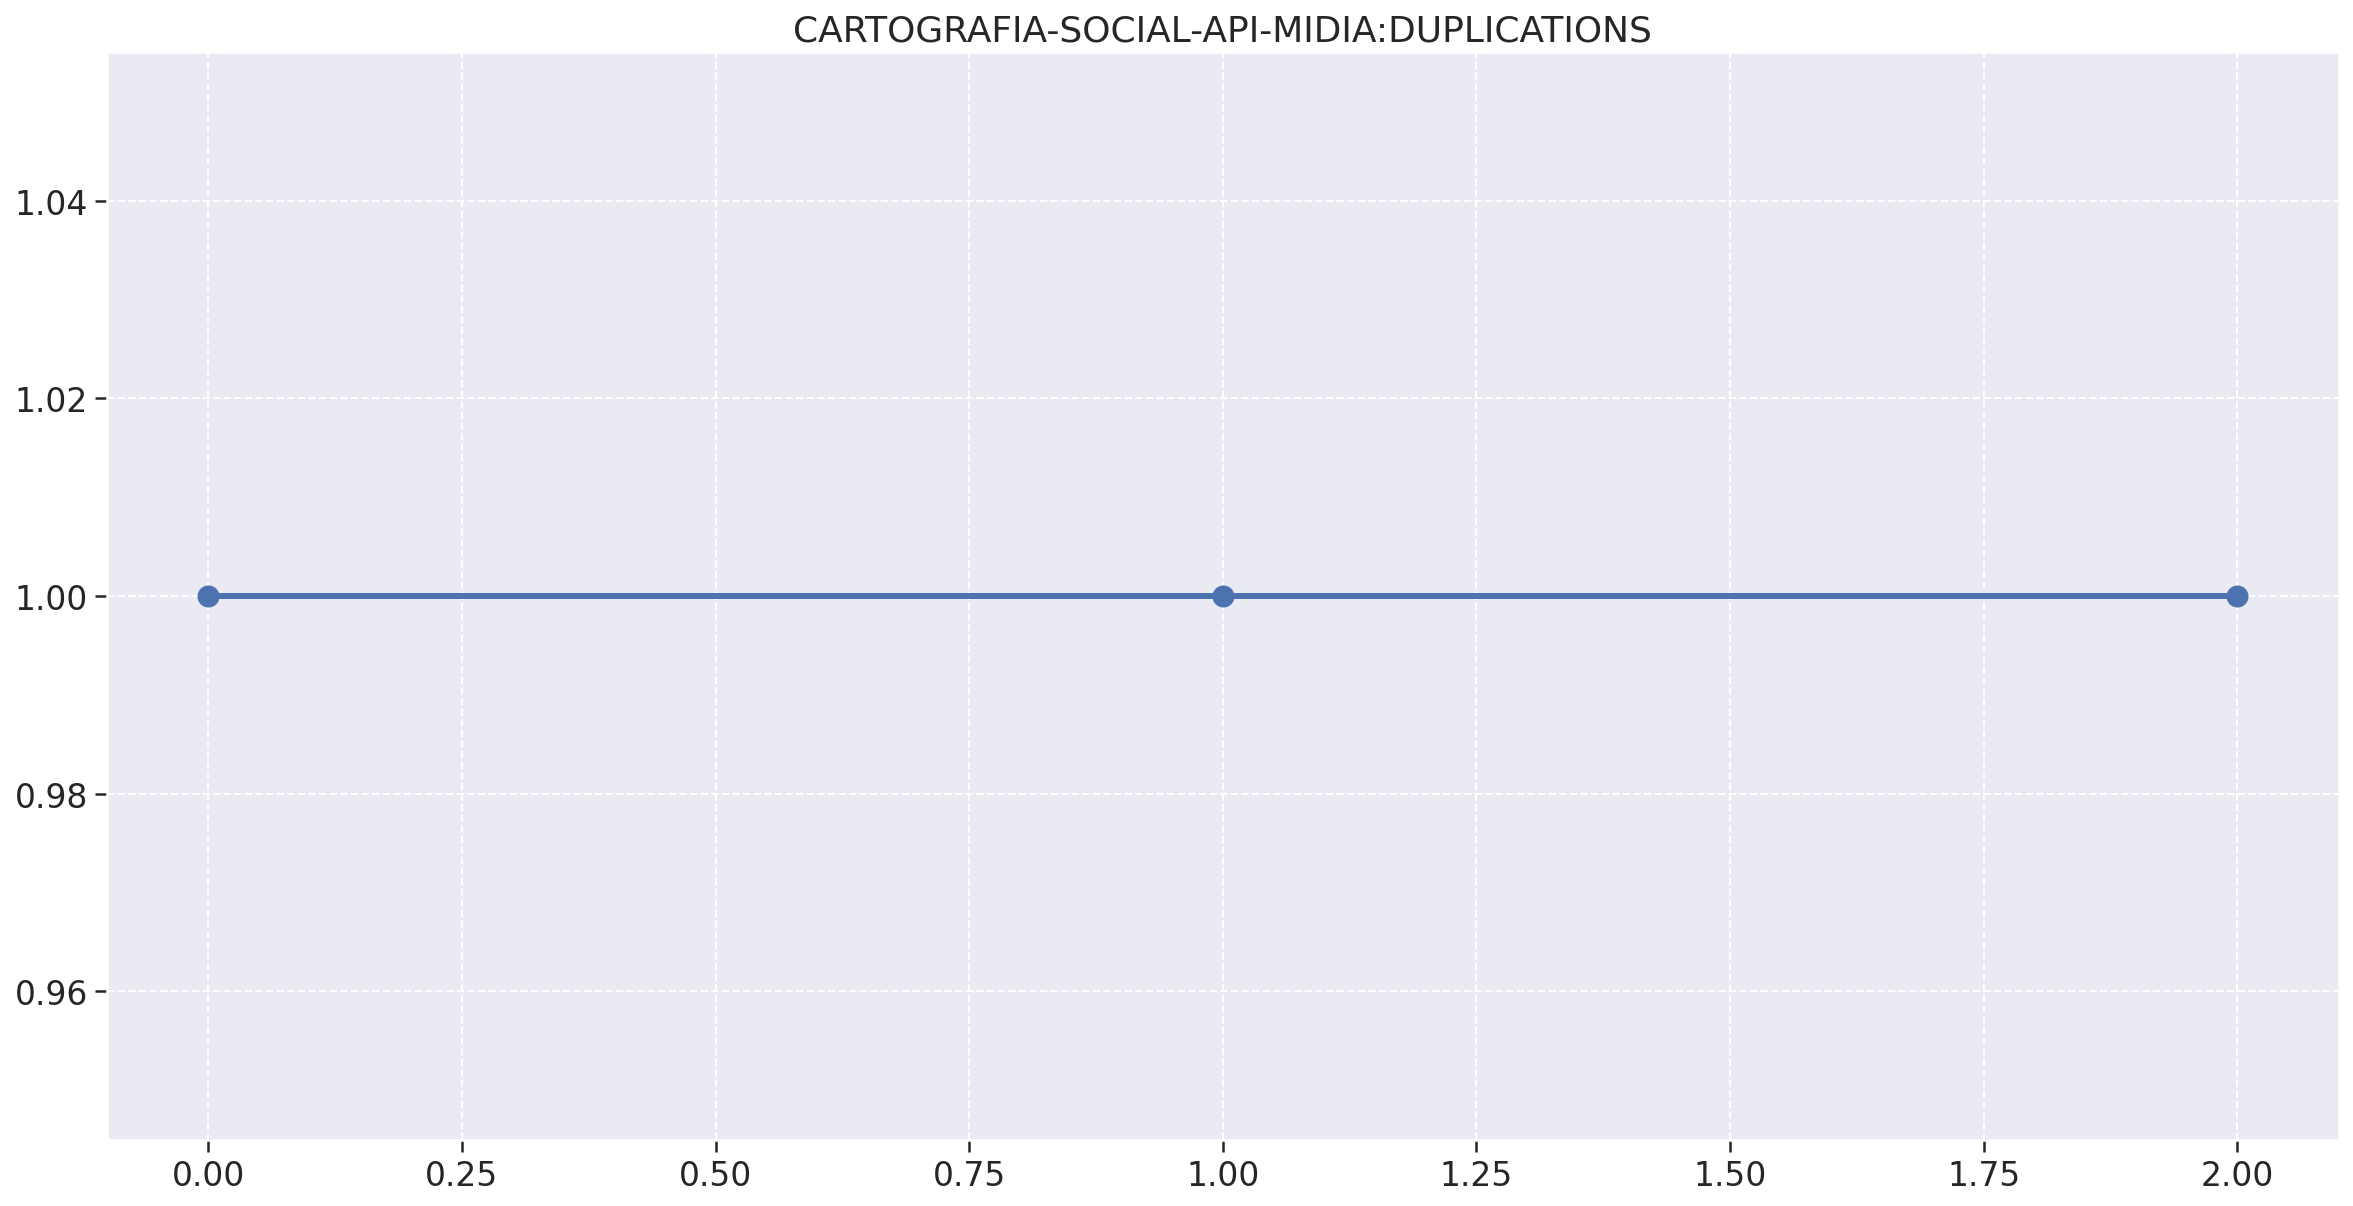

In [1771]:
plot_history(generic_df, repository)

### Estatistica descritiva - midia

In [1772]:
descriptive_statistics(generic_df)

,count,mean,std,min,25%,50%,75%,max,var,median
m1,3.0,0.694444,0.096225,0.583333,0.666667,0.750,0.750,0.750,0.009259,0.750
m2,3.0,0.083333,0.072169,0.000000,0.062500,0.125,0.125,0.125,0.005208,0.125
m3,3.0,1.000000,0.000000,1.000000,1.000000,1.000,1.000,1.000,0.000000,1.000
m4,3.0,1.000000,0.000000,1.000000,1.000000,1.000,1.000,1.000,0.000000,1.000
m5,3.0,1.000000,0.000000,1.000000,1.000000,1.000,1.000,1.000,0.000000,1.000
m6,3.0,1.000000,0.000000,1.000000,1.000000,1.000,1.000,1.000,0.000000,1.000
ncloc,3.0,153.666667,7.371115,148.000000,149.500000,151.000,156.500,162.000,54.333333,151.000


### Cálculo da moda - midia

In [1773]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc
0,0.75,0.125,1.0,1.0,1.0,1.0,148
1,NaN,NaN,NaN,NaN,NaN,NaN,151
2,NaN,NaN,NaN,NaN,NaN,NaN,162


### Tabela de percentis - midia

In [1774]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc
0%,0.583333,0.000,1.0,1.0,1.0,1.0,148.00
10%,0.616667,0.025,1.0,1.0,1.0,1.0,148.60
20%,0.650000,0.050,1.0,1.0,1.0,1.0,149.20
30%,0.683333,0.075,1.0,1.0,1.0,1.0,149.80
40%,0.716667,0.100,1.0,1.0,1.0,1.0,150.40
50%,0.750000,0.125,1.0,1.0,1.0,1.0,151.00
60%,0.750000,0.125,1.0,1.0,1.0,1.0,153.20
70%,0.750000,0.125,1.0,1.0,1.0,1.0,155.40
80%,0.750000,0.125,1.0,1.0,1.0,1.0,157.60
99%,0.750000,0.125,1.0,1.0,1.0,1.0,161.78


### Matriz de correlação - midia

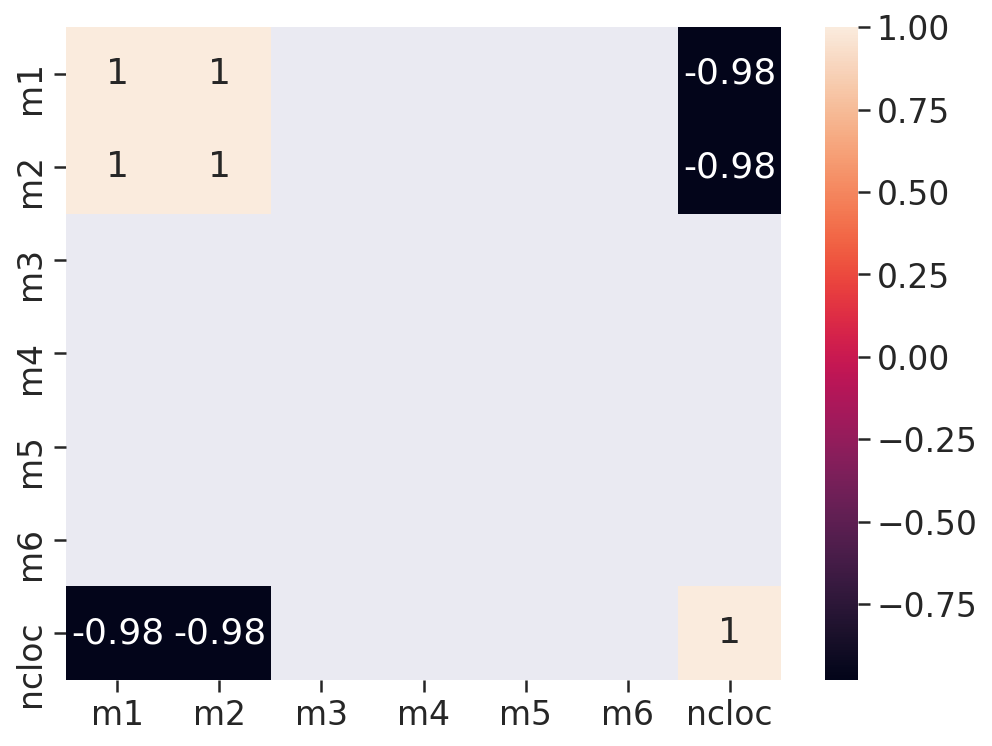

In [1775]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

## Boxplot - midia

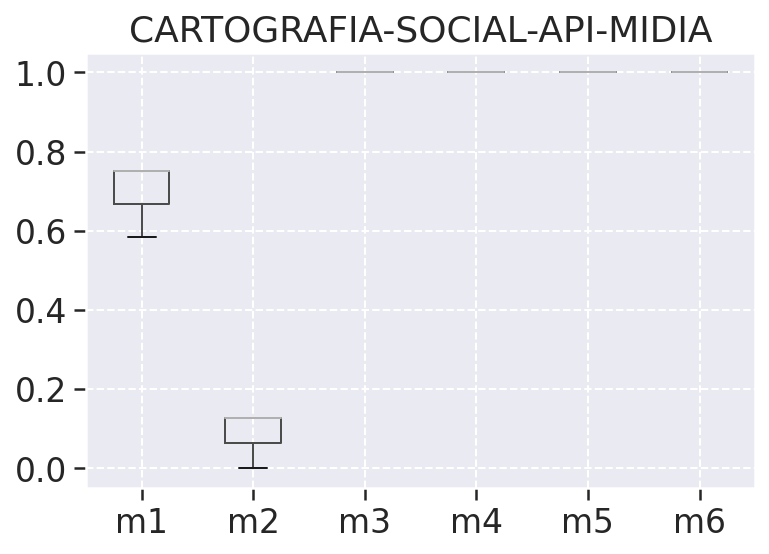

In [1776]:
generate_box(generic_df, repository)

## Análise de  [Maintainability e Reliability] do repositório Cartografia-social-api-users

In [1777]:
generic_df = api_users_metrics.copy()
repository = "CARTOGRAFIA-SOCIAL-API-USERS"

### Plot do Histórico das métricas - Users

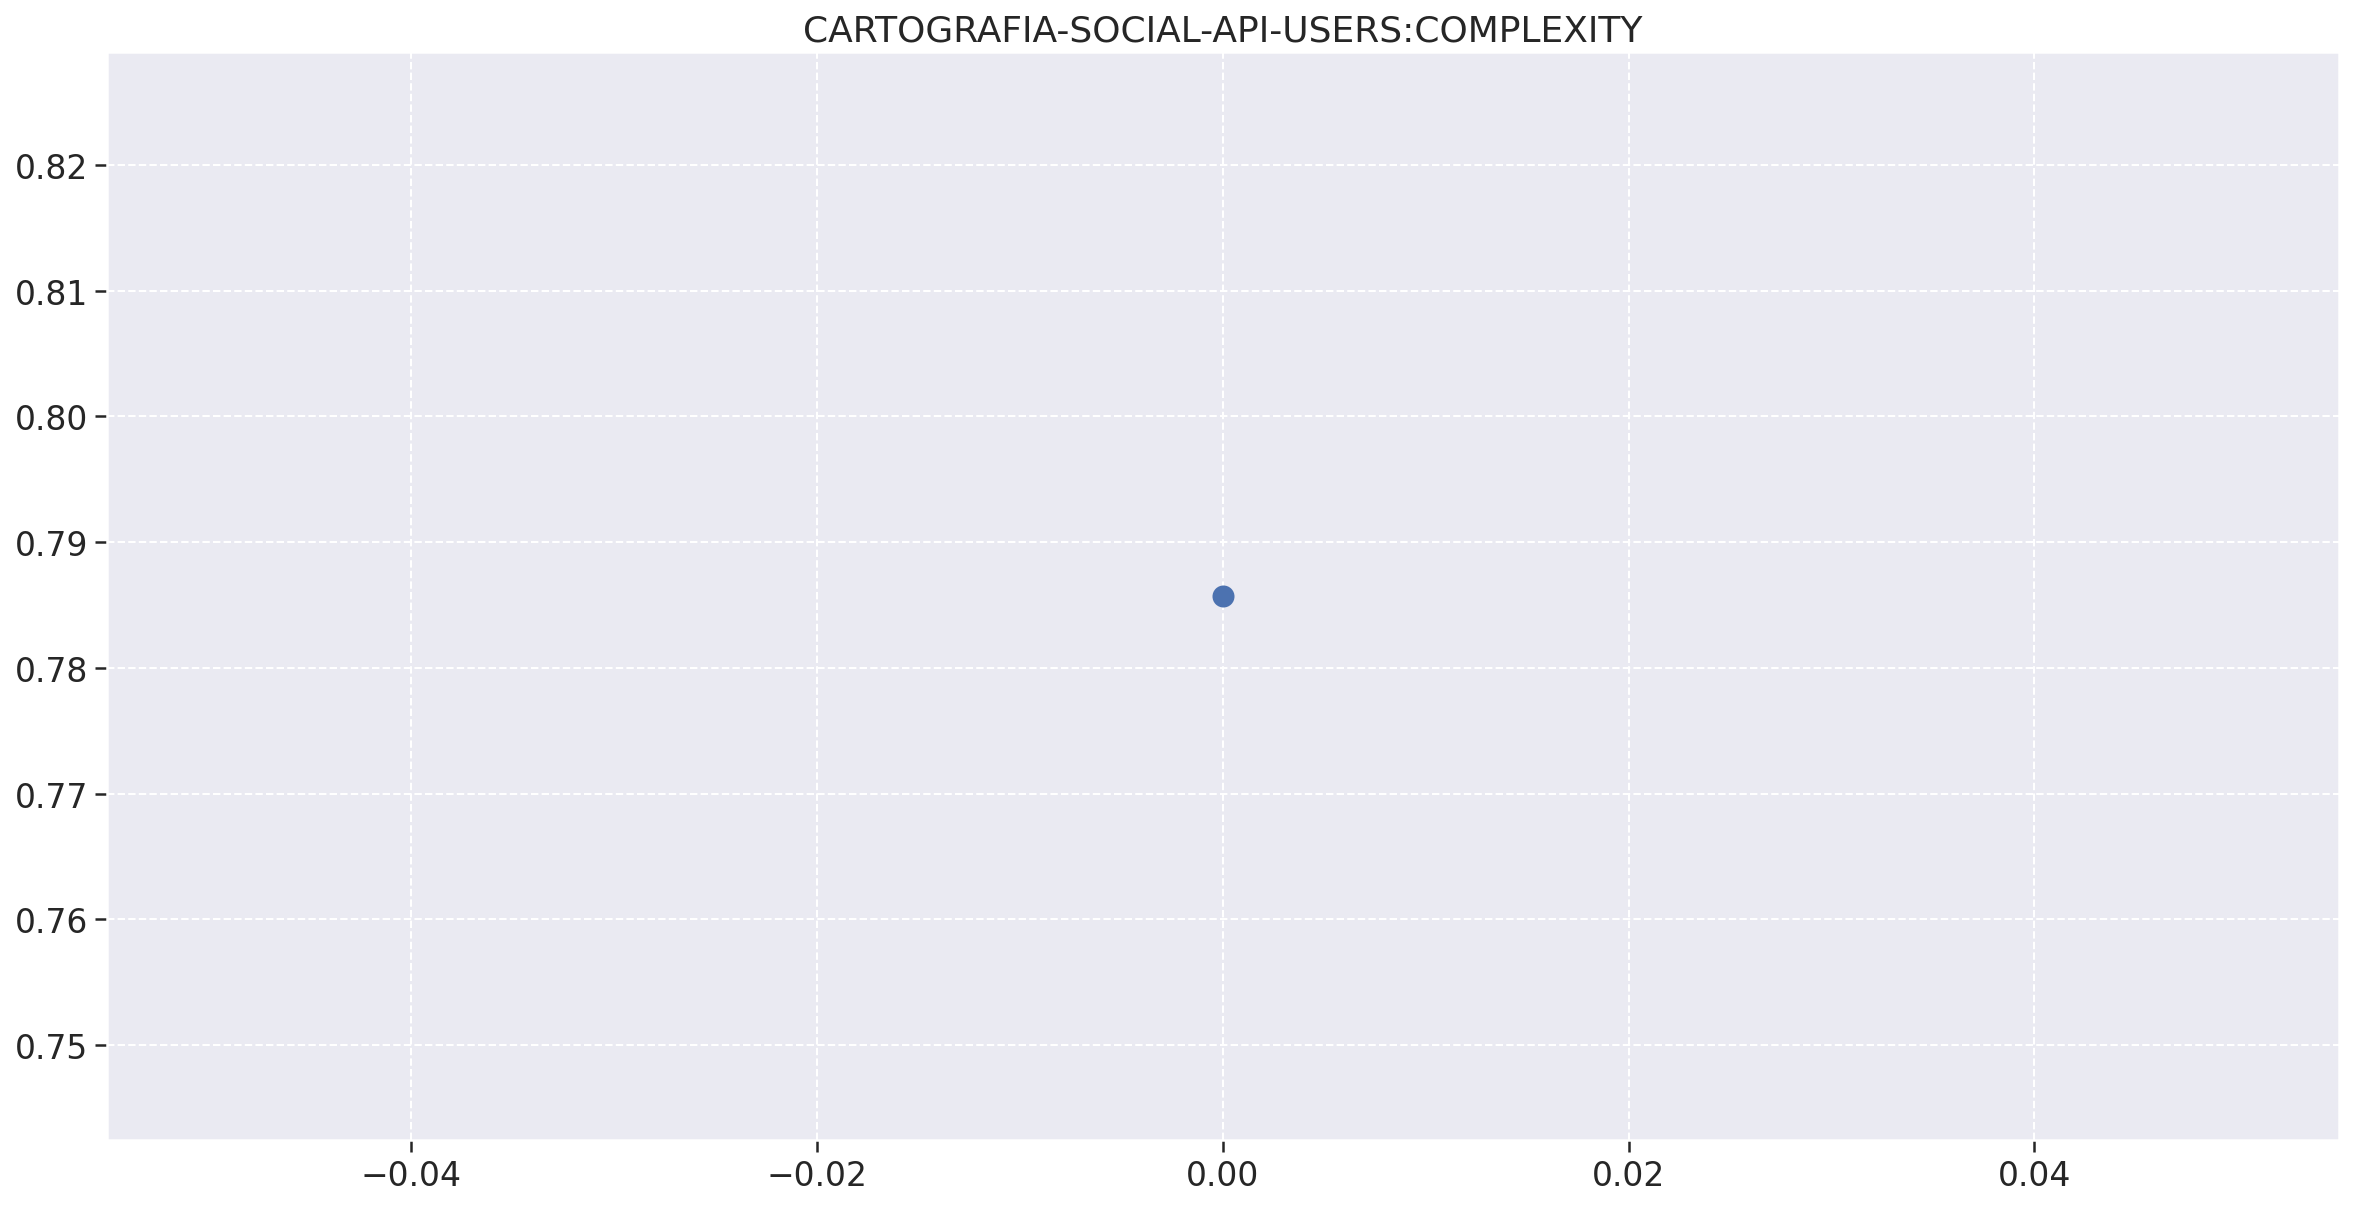

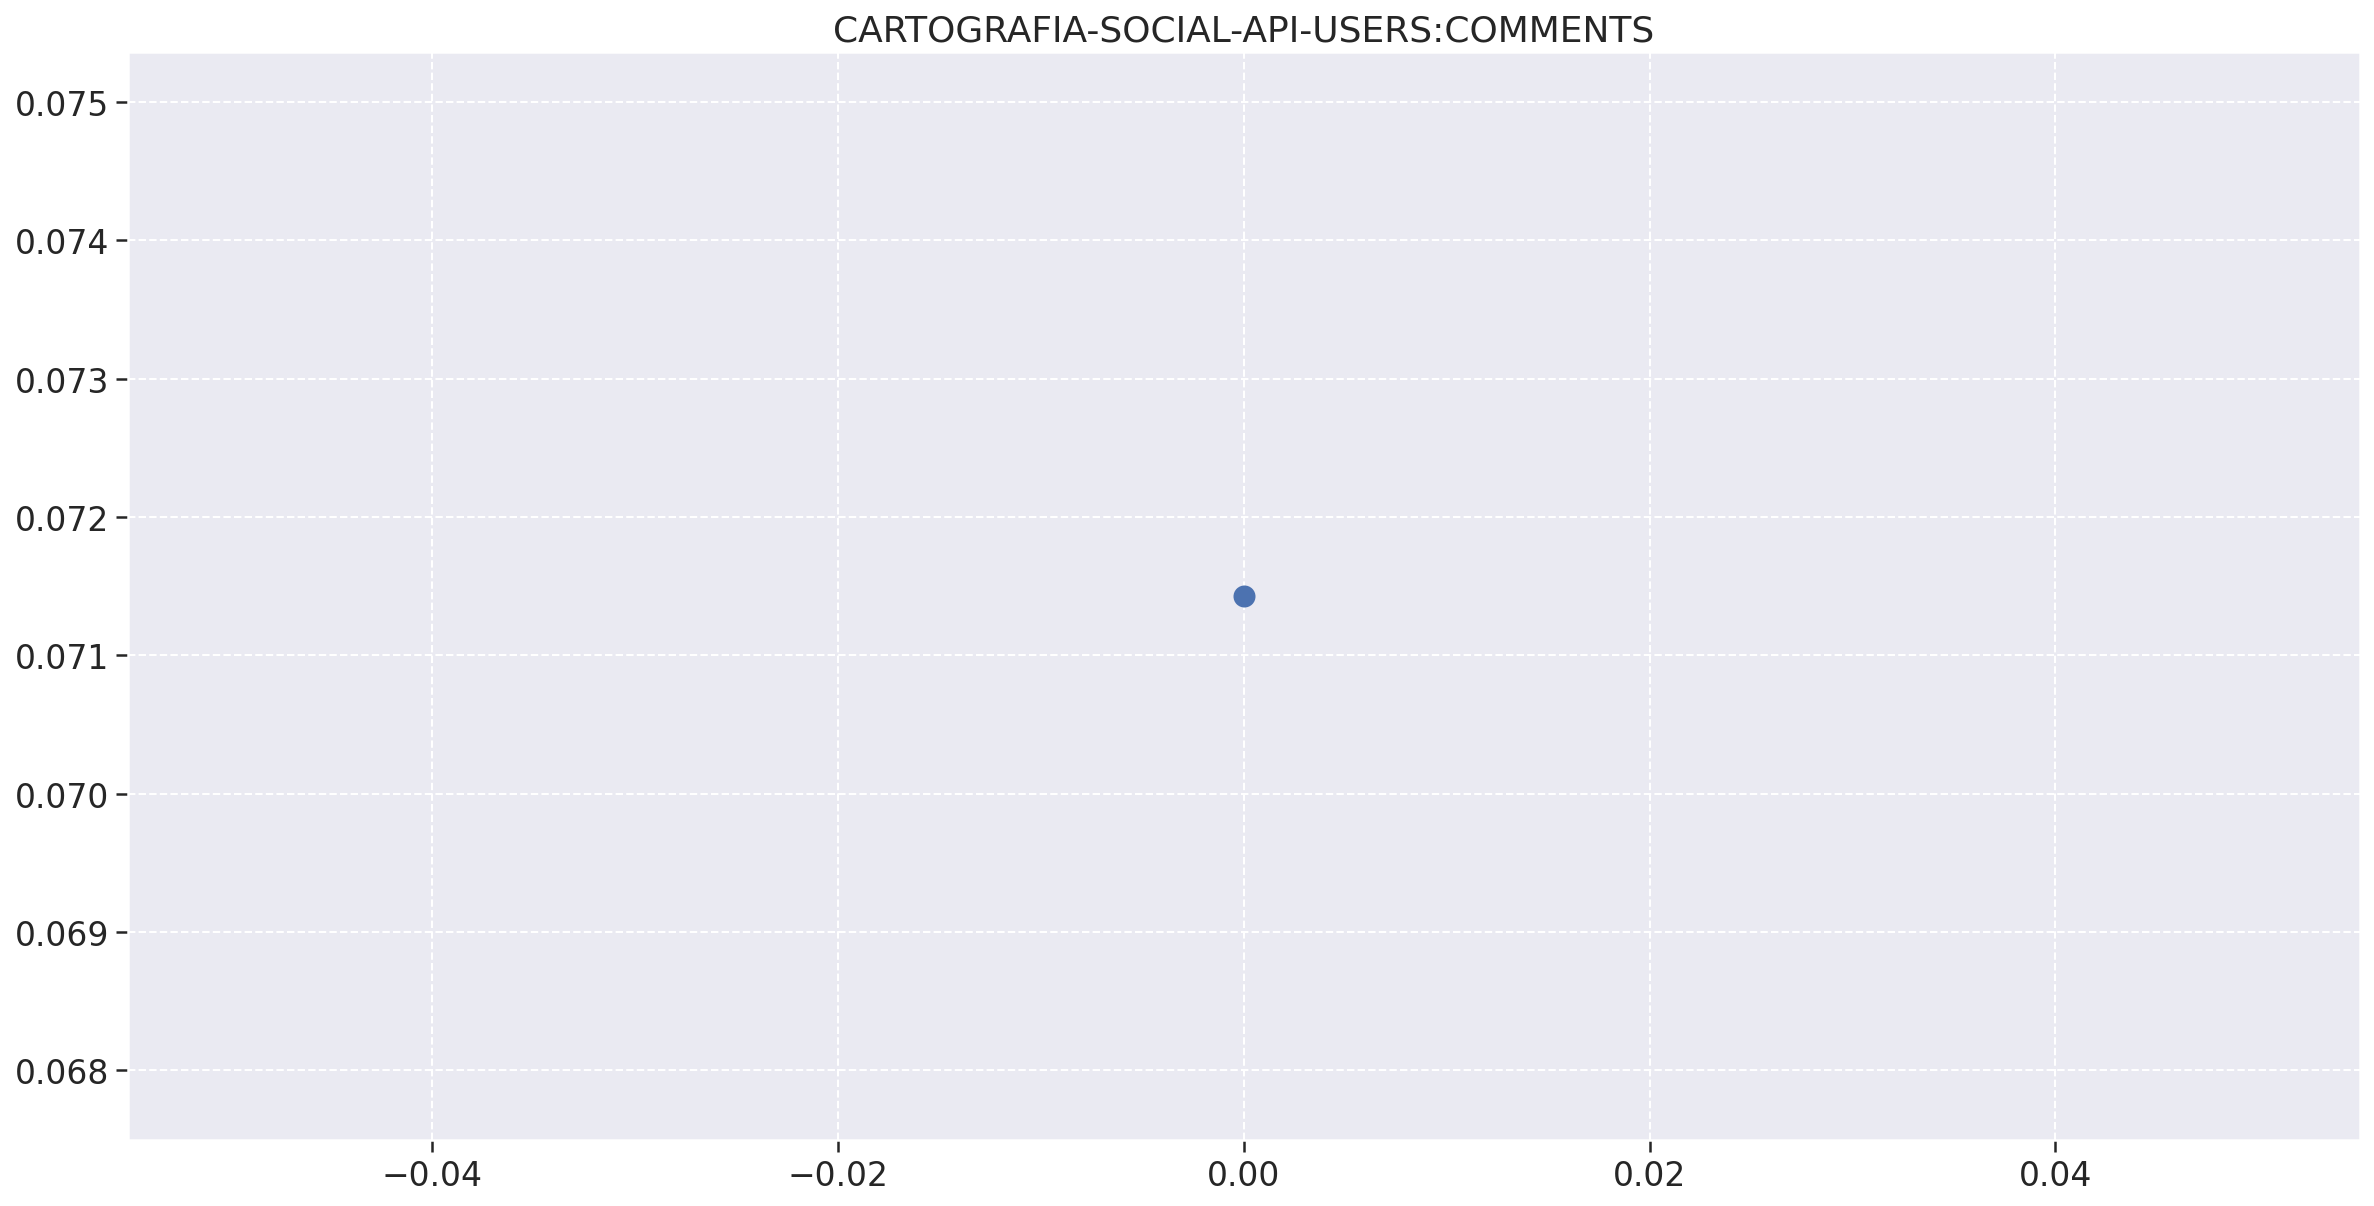

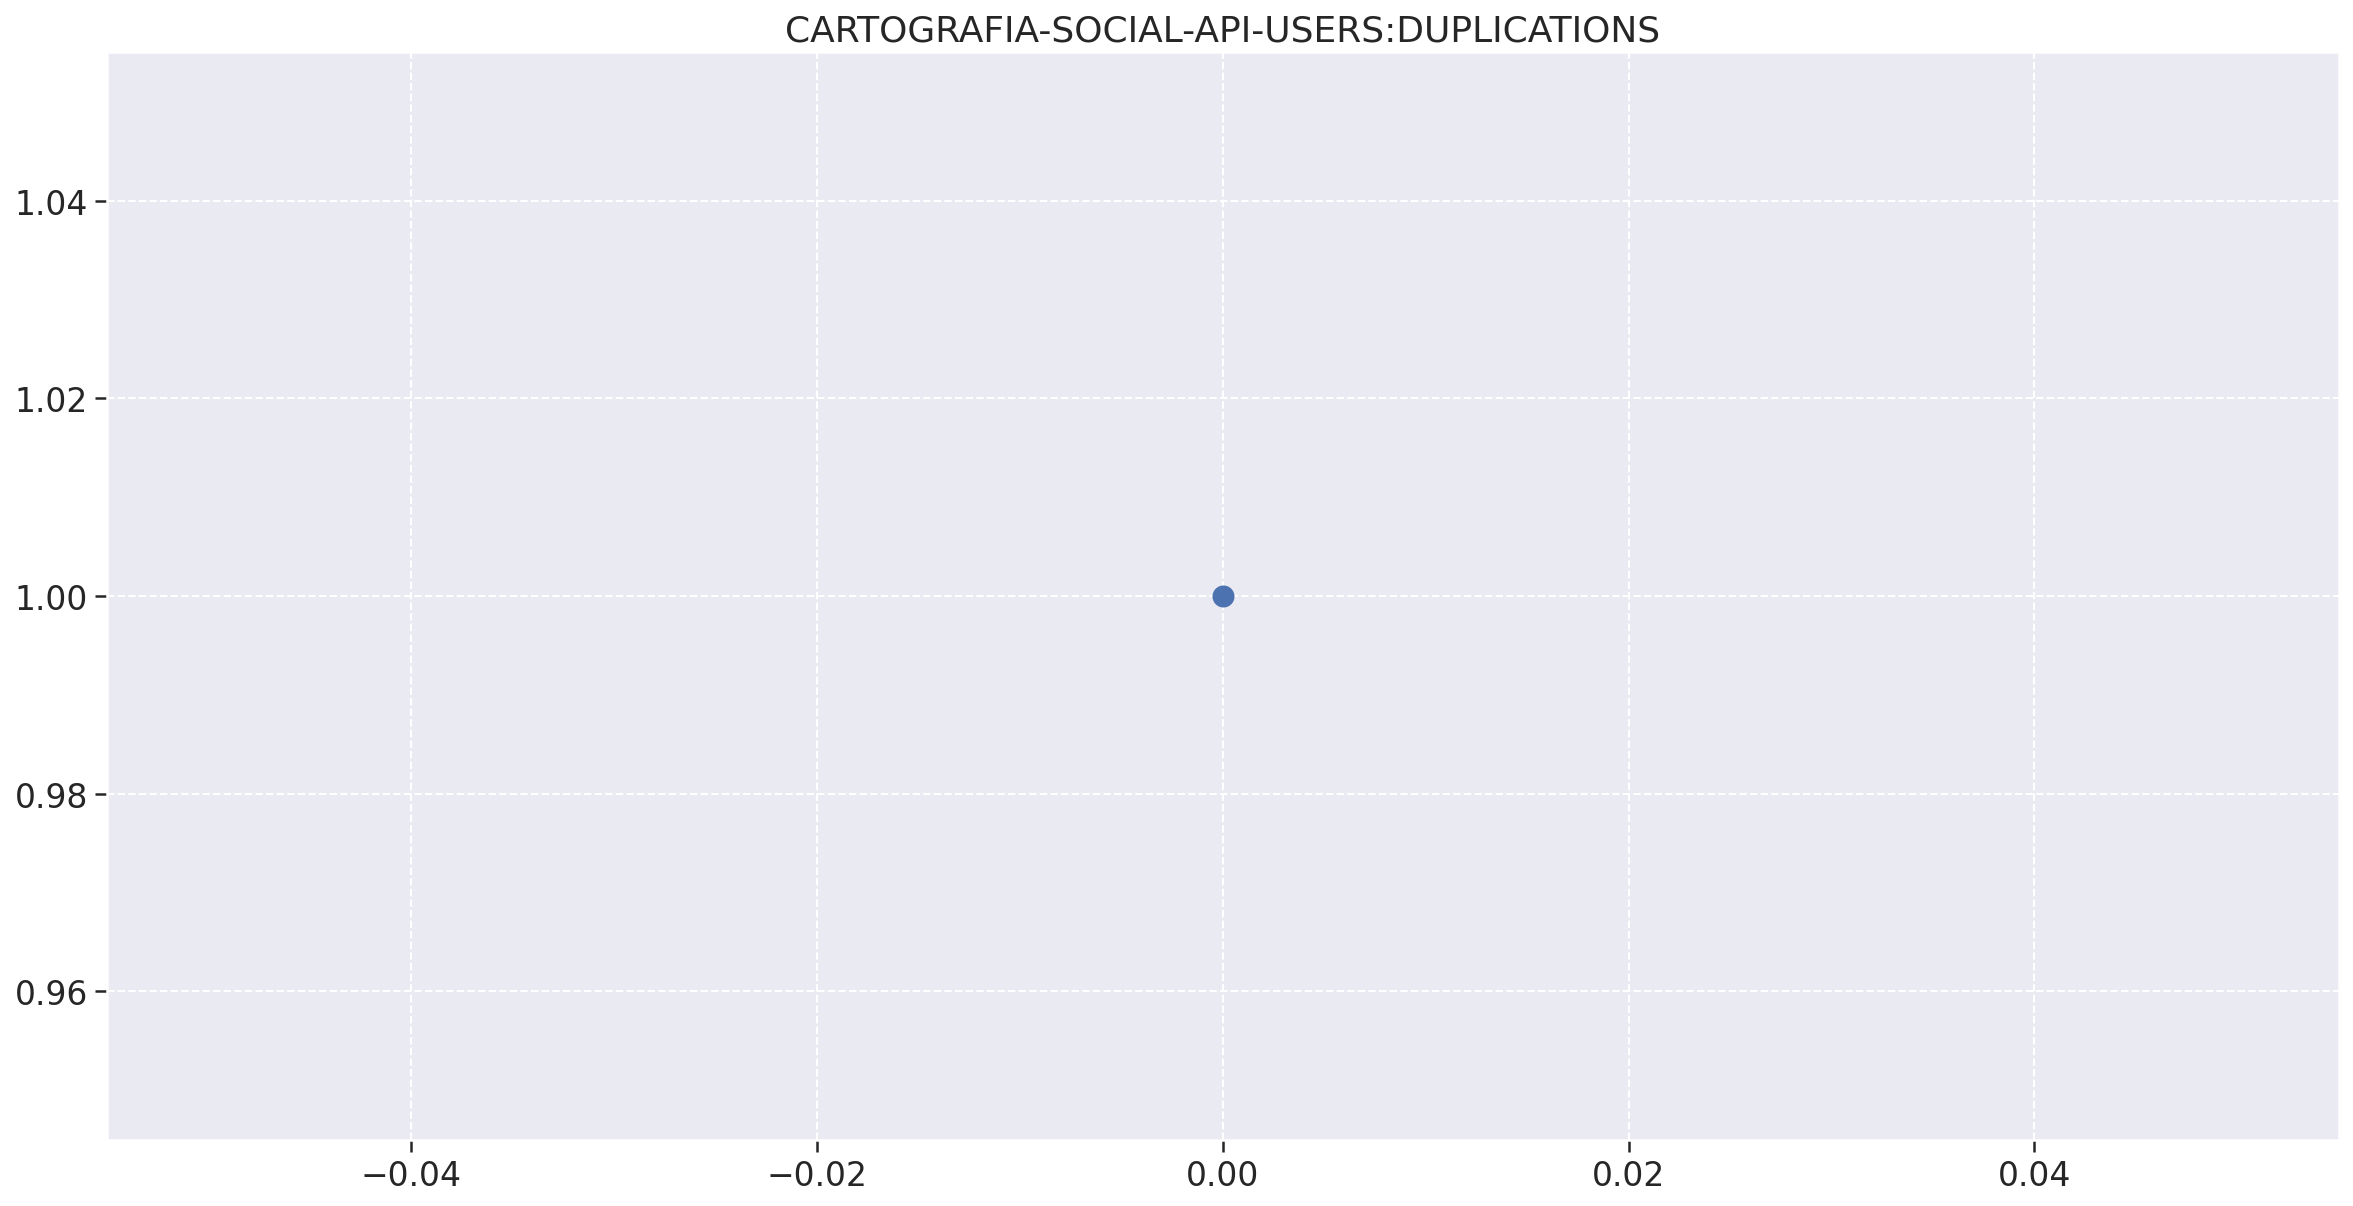

In [1778]:
plot_history(generic_df, repository)

### Estatistica descritiva - Users

In [1779]:
descriptive_statistics(generic_df)

,count,mean,std,min,25%,50%,75%,max,var,median
m1,1.0,0.785714,NaN,0.785714,0.785714,0.785714,0.785714,0.785714,NaN,0.785714
m2,1.0,0.071429,NaN,0.071429,0.071429,0.071429,0.071429,0.071429,NaN,0.071429
m3,1.0,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000
m4,1.0,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000
m5,1.0,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000
m6,1.0,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000
ncloc,1.0,601.000000,NaN,601.000000,601.000000,601.000000,601.000000,601.000000,NaN,601.000000


### Cálculo da moda - Users

In [1780]:
generic_df.mode(numeric_only=True)

,m1,m2,m3,m4,m5,m6,ncloc
0,0.785714,0.071429,1.0,1.0,1.0,1.0,601


### Tabela de percentis - Users

In [1781]:
descriptive_per(generic_df)

,m1,m2,m3,m4,m5,m6,ncloc
0%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
10%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
20%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
30%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
40%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
50%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
60%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
70%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
80%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0
99%,0.785714,0.071429,1.0,1.0,1.0,1.0,601.0


### Matriz de correlação - Users

/home/lolo/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/lolo/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


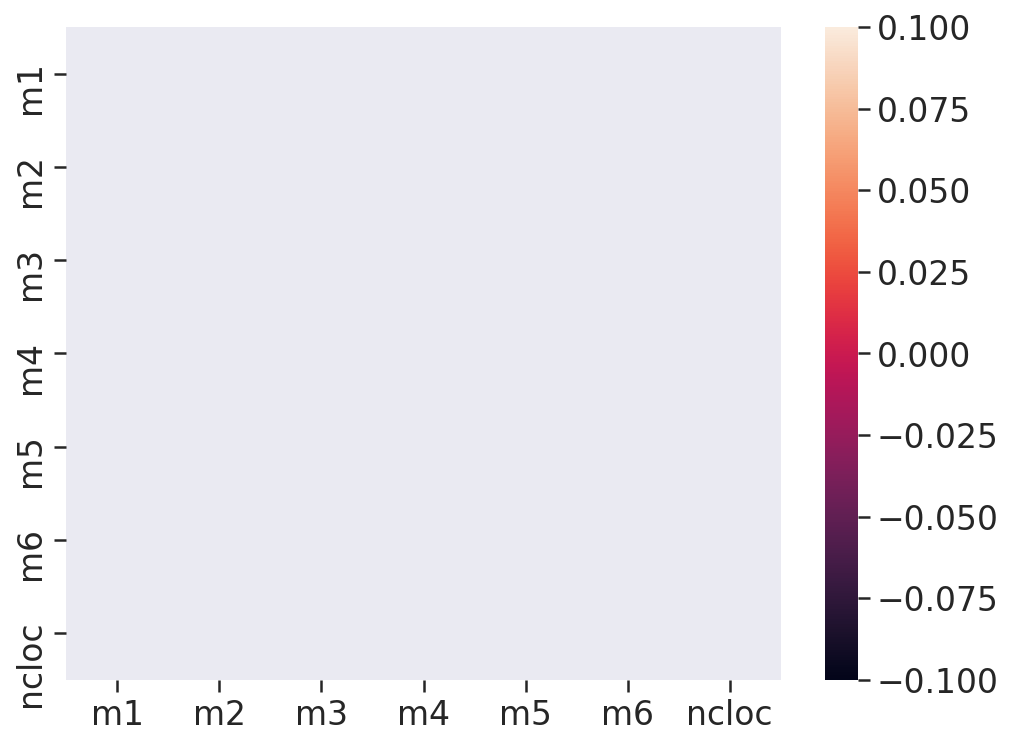

In [1782]:
corr_df = correlationMatrix(generic_df)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()
#corr_df.style.background_gradient(cmap='coolwarm')

### Boxplot - Users

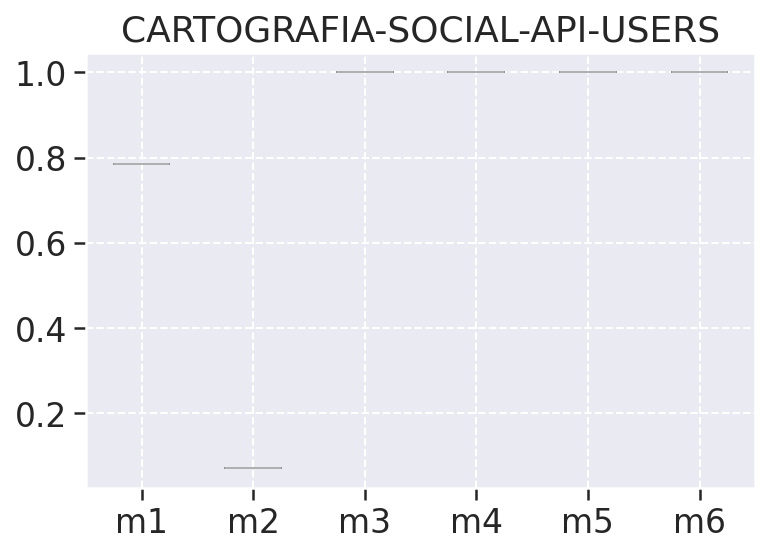

In [1783]:
generate_box(generic_df, repository)

### Sub characteristic aggregation

- You must do this for each of your repositories

In [1784]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

api_comunidades_metrics['code_quality'] = ((api_comunidades_metrics['m1']*pm1) + (api_comunidades_metrics['m2']*pm2) + (api_comunidades_metrics['m3']*pm3)) * psc1
api_gateway_metrics['code_quality'] = ((api_gateway_metrics['m1']*pm1) + (api_gateway_metrics['m2']*pm2) + (api_gateway_metrics['m3']*pm3)) * psc1
api_mapas_metrics['code_quality'] = ((api_mapas_metrics['m1']*pm1) + (api_mapas_metrics['m2']*pm2) + (api_mapas_metrics['m3']*pm3)) * psc1
api_midia_metrics['code_quality'] = ((api_midia_metrics['m1']*pm1) + (api_midia_metrics['m2']*pm2) + (api_midia_metrics['m3']*pm3)) * psc1
api_users_metrics['code_quality'] = ((api_users_metrics['m1']*pm1) + (api_users_metrics['m2']*pm2) + (api_users_metrics['m3']*pm3)) * psc1
front_metrics['code_quality'] = ((front_metrics['m1']*pm1) + (front_metrics['m2']*pm2) + (front_metrics['m3']*pm3)) * psc1
...

api_comunidades_metrics['testing_status'] = ((api_comunidades_metrics['m4']*pm4) + (api_comunidades_metrics['m5']*pm5) + (api_comunidades_metrics['m6']*pm6)) * psc2
api_gateway_metrics['testing_status'] = ((api_gateway_metrics['m4']*pm4) + (api_gateway_metrics['m5']*pm5) + (api_gateway_metrics['m6']*pm6)) * psc2
api_mapas_metrics['testing_status'] = ((api_mapas_metrics['m4']*pm4) + (api_mapas_metrics['m5']*pm5) + (api_mapas_metrics['m6']*pm6)) * psc2
api_midia_metrics['testing_status'] = ((api_midia_metrics['m4']*pm4) + (api_midia_metrics['m5']*pm5) + (api_midia_metrics['m6']*pm6)) * psc2
api_users_metrics['testing_status'] = ((api_users_metrics['m4']*pm4) + (api_users_metrics['m5']*pm5) + (api_users_metrics['m6']*pm6)) * psc2
front_metrics['testing_status'] = ((front_metrics['m4']*pm4) + (front_metrics['m5']*pm5) + (front_metrics['m6']*pm6)) * psc2
...

Ellipsis

In [1785]:
metrics_df = pd.concat([api_comunidades_metrics, api_gateway_metrics, api_mapas_metrics, api_midia_metrics, api_users_metrics, front_metrics], ignore_index=True)
metrics_df['Maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['Maintainability'] + metrics_df['Reliability']

In [1786]:
# ANALYSIS_DATE FORMAT: MM-DD-YYYY

metrics_df.to_excel('data/fga-eps-mds-2021_1-Cartografia-Social-ANALYSYS.xlsx', index = False)
metrics_df.to_csv('data/fga-eps-mds-2021_1-Cartografia-Social-ANALYSYS.csv', index = False)

# Gráfico de Dispersão - Qualidade total

- O gráfico de dispersão geralmente mostra a correlação entre duas váriaveis e como elas se afetam, aqui os pares de dados que se relacionam é o de manutenibilidade e confiabilidade. Tanto a métrica de confiabilidade quanto a de manutenibilidade são métricas de qualidade de software definidas na ISO 9121, e elas nos ajudam a definir aspectos de qualidade externa e interna do produto e fazem parte do modelo de qualidade, além disso temos tambeḿ sub-aspectos em cada uma dessas caracteristica que as fazem tem o seu aspecto principal. Cada uma dessas métricas indicam alguns aspectos do nosso produto e iremos abordalos mais a fundo para uma melhor compreensão do nosso gŕafico de dispersão.

- Manutenibilidade (Maintainability): Essa métrica nos diz respeito a capacidade do produto de software de ser modificado. As modificações podem incluir correções, melhorias ou adaptações. Usando as métricas m1, m2, m3, fizemos um cálculo da manutenibilidade dos repositórios do projeto afim de compararmos com a métrica de confiabilidade. 

- Confiabilidade (Reliability): Capacidade do produto de software de manter um nível de desempenho especificado, quando usado em condições especificadas.Usando as métricas m4, m5, m6, fizemos um cálculo da confiabilidade dos repositórios do projeto afim de compararmos com a métrica de manutenibilidade.

## Interpretando o Gráfico de Dispersão

Com base nas definições citadas acima podemos então interpretar o gráfico de dispersão dos aspectos de qualidade citados acerca dos repositórios do projeto, esse gráfico plota os pontos de qualidade de todos os repositórios e correlaciona manutenibilidade x confiabilidade além de nos mostrar uma barra lateral que indica a qualidade total. Esse gráfico tem escala que vai de 0 a 1 sendo 0 nenhuma qualidade e 1 qualidade máxima. 

Podemos observar que o projeto não conseguiu atingir o nível um de qualidade das métricas citadas porém chegou em um bom valor de 0.825, podemos ver também que quanto mais a manutenibilidade cresce, mais cresce a confiabilidade do projeto o que também acarreta uma subida no aspecto de qualidade geral.

Apesar de não termos conseguido chegar a uma qualidade máxima ao decorrer do projeto a qualidade foi melhorando e isso decorre de uma maior cobertura de testes e também de uma melhor implementação de código e diminuição de complexidade.


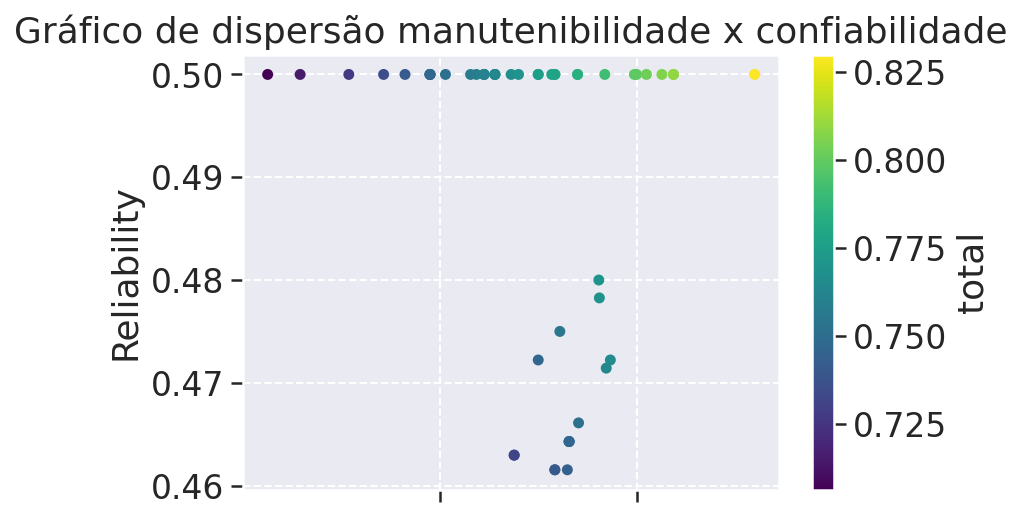

<Figure size 1440x720 with 0 Axes>

In [1787]:
metrics_df
dataFrame = pd.DataFrame(data=metrics_df, columns=['Maintainability','Reliability', 'total']);
dataFrame.plot.scatter(x='Maintainability', y='Reliability', c='total', title= "Gráfico de dispersão manutenibilidade x confiabilidade",  colormap='viridis');

fig = plt.figure(figsize=(20, 10))
plt.show(block=True);

# Gráfico de Histograma

O gráfico de histograma geralmente mostra a ocorrência de um determinado valor em um determinado intervalo, um exemplo fácil para se entender um gráfico de histograma e plotar um gráfico de número de jogadores de futebol de um time x Idade, ou seja, esses dados em um gráfico de histograma nos mostram a quantidade de jogadores de uma determinada idade. 

No nosso projeto usaremos esse gráfico para plotar o ocorrência das métricas de qualidade do nosso dataset final, afim de analisarmos a Manutenibilidade e a Confiabilidade do nosso projeto, como todas as métricas ocorrem no intervalo de 0 a 1 sendo 0 nenhuma qualidade, e 1 a maior qualidade possível.

As métricas analisadas são as métricas de m1 a m6, Maintainability, Reliability e total, a ultima reprensenta um valor de qualidade de cada release de cada repositório com base nas métricas citadas anteriormente

<Figure size 1440x288 with 0 Axes>

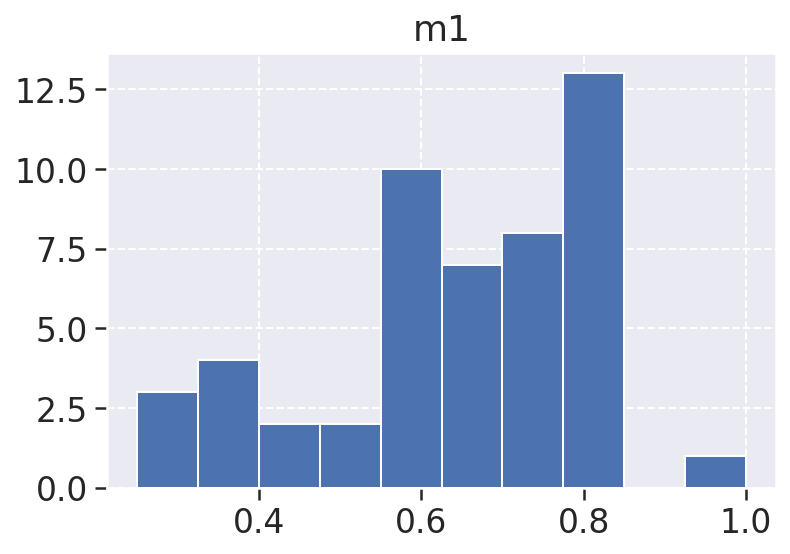

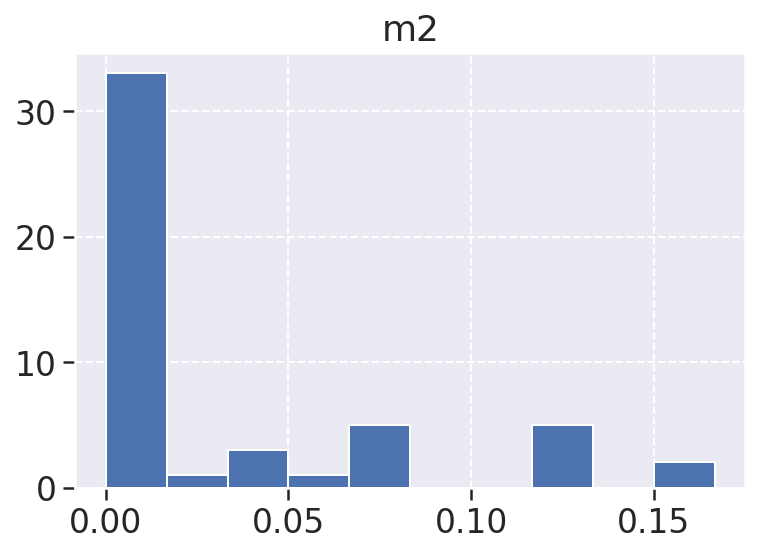

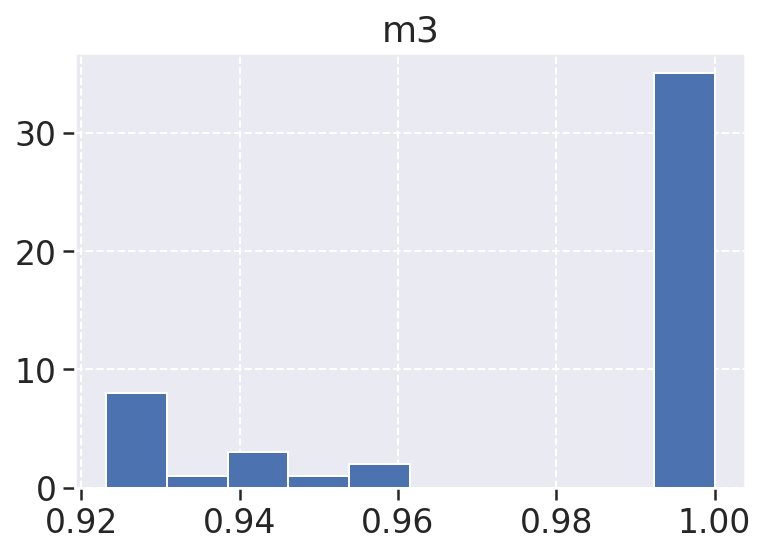

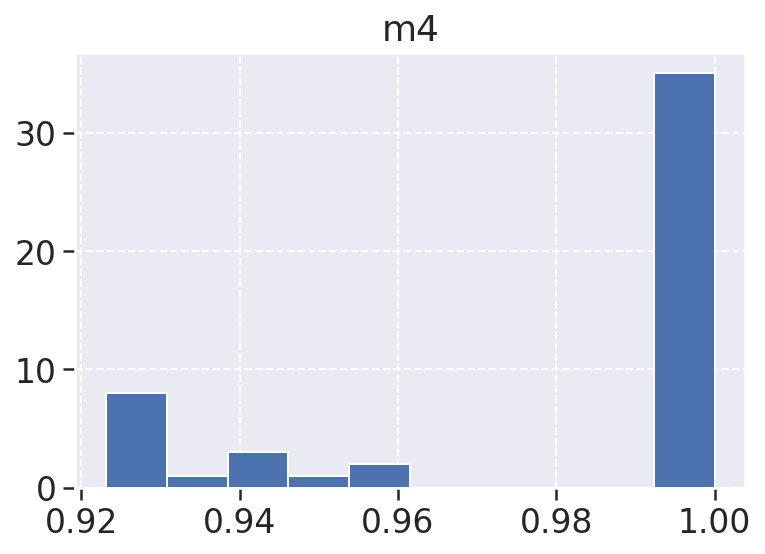

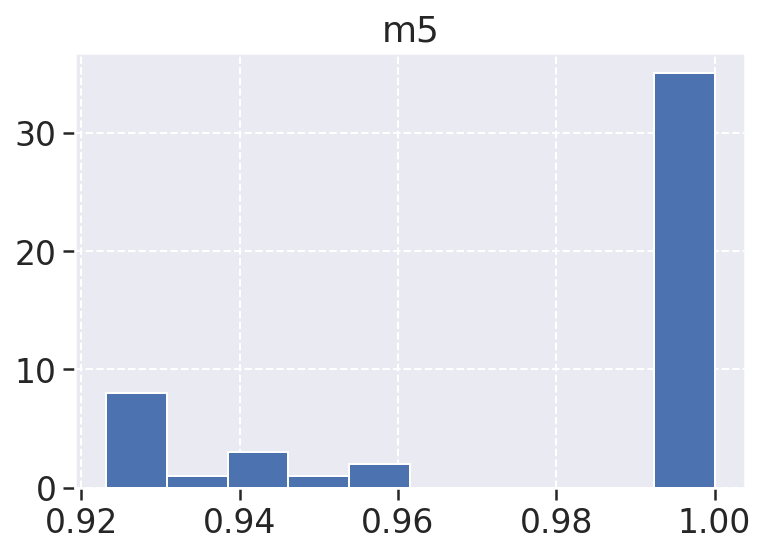

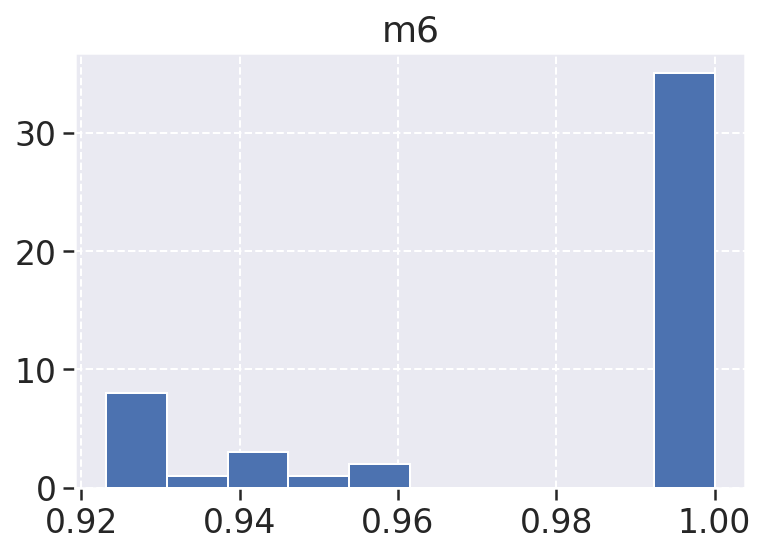

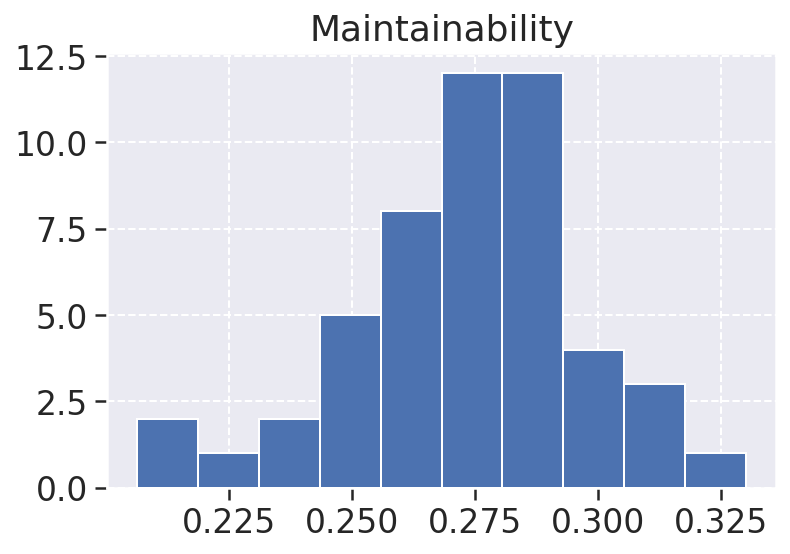

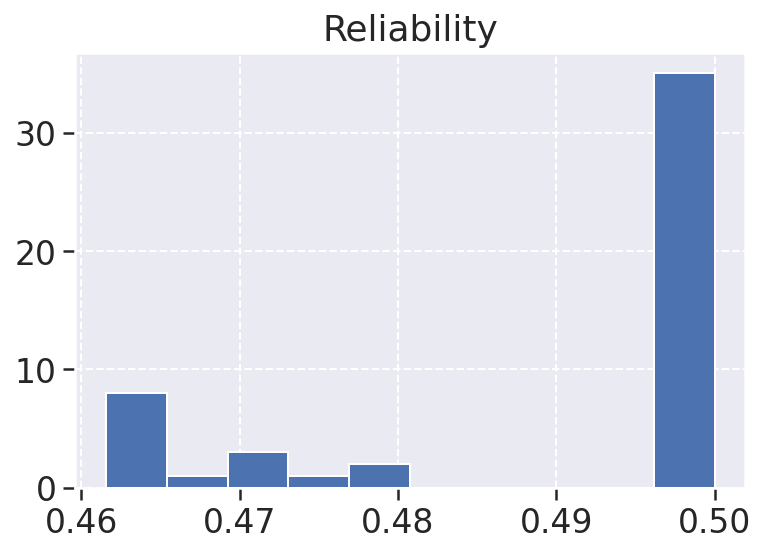

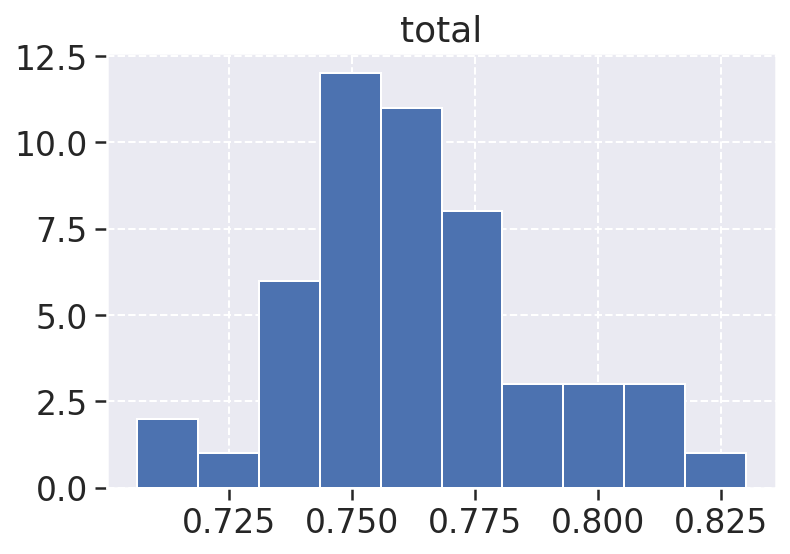

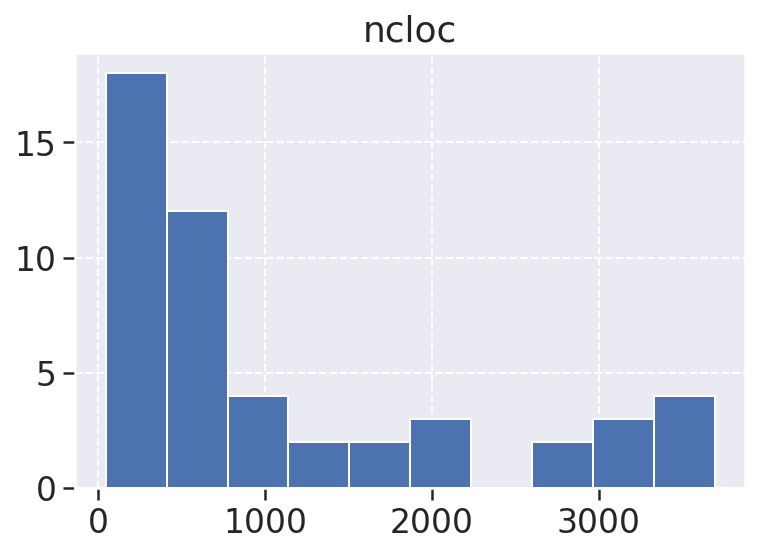

In [1788]:
plt.figure(figsize=(20, 4))

url= 'data/fga-eps-mds-2021_1-Cartografia-Social-ANALYSYS.xlsx'
df= pd.read_excel(url)
df.head()

df.hist(column='m1')
df.hist(column='m2')
df.hist(column='m3')
df.hist(column='m4')
df.hist(column='m5')
df.hist(column='m6')
df.hist(column='Maintainability')
df.hist(column='Reliability')
df.hist(column='total')
plt.show()

In [1789]:
#url= 'data/fga-eps-mds-2021_1-Cartografia-Social-ANALYSYS.xlsx'
#df= pd.read_excel(url)
#df.head()